In [1]:
import torch
torch.cuda.is_available()

False

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [3]:

import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
%matplotlib inline
pd.options.mode.chained_assignment = None
from sklearn.metrics import confusion_matrix, recall_score, precision_score, accuracy_score, f1_score,roc_auc_score


In [4]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.optim import Adam, SGD, Adagrad, AdamW, Adadelta 
from torch.nn.utils import clip_grad_norm_
from IPython.display import clear_output
import pickle

In [5]:
#data frame with the filtered topic labels and features that characterize each data entry:

file = open("tfidf_topics.pkl",'rb')
df = pickle.load(file)
file.close()


Text(0, 0.5, 'Number of topics')

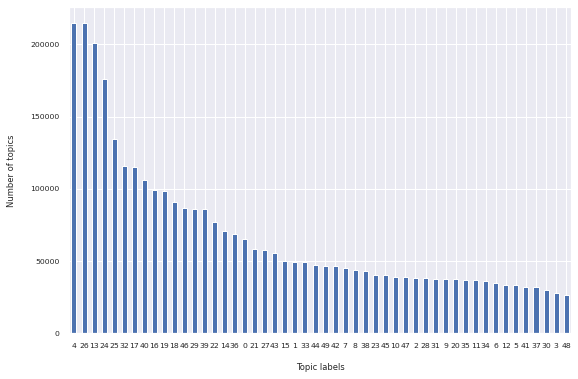

In [6]:
sns.set(font_scale=0.7)
df['text_tokens'].value_counts().plot(kind='bar', figsize=(9, 6), rot=0)
plt.xlabel("Topic labels", labelpad=14)
plt.ylabel("Number of topics", labelpad=14)
#plt.title("Histogram showing frequency of topics in the dataset", y=1.02);

In [7]:
#Tweet count for all the users considered
df['engaging_user_id'].value_counts()

72C2BE10D3673447A6D596E12C0523DA    502
3396F36ADFF2A01A34C0CB3486CABFEE    388
5049F4AC51D668D064214377EB38A8D3    320
3FC1A3B3B9C8D1BD6673C3B5B65A6E91    308
F1D8FA7C91B5EE653330E80D48C77AD1    297
                                   ... 
062A08DC2A6FBD0A518C90418EAEABF6     21
03EFBD99E8009133D7CAC21B61BD9500     21
F6B53E43B56A80BEC87747A3F32CFB77     21
C15AF762411C04BD74361FCF93BF4268     21
15A3B2A2EC840486E359000D6DD5853E     21
Name: engaging_user_id, Length: 107017, dtype: int64

In [8]:
#Convert date to yyyy-mm-dd hh:mm:ss format
import datetime
df['tweet_timestamp'] = df["tweet_timestamp"].apply(lambda x: datetime.datetime.fromtimestamp(x)) 

In [9]:
t1 = df[(df["tweet_timestamp"] >= '2020-02-05 18:00:00') & (df["tweet_timestamp"] < '2020-02-06 06:00:00')]
t2 = df[(df["tweet_timestamp"] >= '2020-02-06 06:00:00') & (df["tweet_timestamp"] < '2020-02-06 18:00:00')]
t3 = df[(df["tweet_timestamp"] >= '2020-02-06 18:00:00') & (df["tweet_timestamp"] < '2020-02-07 06:00:00')]
t4 = df[(df["tweet_timestamp"] >= '2020-02-07 06:00:00') & (df["tweet_timestamp"] < '2020-02-07 18:00:00')]
t5 = df[(df["tweet_timestamp"] >= '2020-02-07 18:00:00') & (df["tweet_timestamp"] < '2020-02-08 06:00:00')]
t6 = df[(df["tweet_timestamp"] >= '2020-02-08 06:00:00') & (df["tweet_timestamp"] < '2020-02-08 18:00:00')]
t7 = df[(df["tweet_timestamp"] >= '2020-02-08 18:00:00') & (df["tweet_timestamp"] < '2020-02-09 06:00:00')]
t8 = df[(df["tweet_timestamp"] >= '2020-02-09 06:00:00') & (df["tweet_timestamp"] < '2020-02-09 18:00:00')]
t9 = df[(df["tweet_timestamp"] >= '2020-02-09 18:00:00') & (df["tweet_timestamp"] < '2020-02-10 06:00:00')]
t10 = df[(df["tweet_timestamp"] >= '2020-02-10 06:00:00') & (df["tweet_timestamp"] < '2020-02-10 18:00:00')]
t11 = df[(df["tweet_timestamp"] >= '2020-02-10 18:00:00') & (df["tweet_timestamp"] < '2020-02-11 06:00:00')]
t12 = df[(df["tweet_timestamp"] >= '2020-02-11 06:00:00') & (df["tweet_timestamp"] < '2020-02-11 18:00:00')]
t13 = df[(df["tweet_timestamp"] >= '2020-02-11 18:00:00') & (df["tweet_timestamp"] < '2020-02-12 06:00:00')]
t14 = df[(df["tweet_timestamp"] >= '2020-02-12 06:00:00') & (df["tweet_timestamp"] < '2020-02-12 18:00:00')]

# Each time period is 12 hrs
# Engagement frequency of user is from time periods t1 to t12 during training
# Recent history of user is considered from time periods t9 to t12 training 
# Current time period is considered as t13
# Testing will be carried out on time period t14


In [10]:


columns = ['reply_timestamp','tweet_timestamp', 'tweet_id',"retweet_timestamp","retweet_with_comment_timestamp","like_timestamp"]


In [11]:
#Recent history t9 to t12 for training

t9['retweet'] = np.where(pd.notnull(t9['retweet_timestamp']), 1, 0)
t9.drop(columns, axis=1,inplace=True)
t_9 = t9.groupby(['engaging_user_id', 'text_tokens'])[['retweet']].agg('sum')
t9_history = t_9.pivot_table(index='engaging_user_id', columns='text_tokens', values='retweet')
t9_history.fillna(0,inplace = True)
history_t9 = pd.DataFrame(t9_history.to_records())
for col in history_t9.columns:
  if col != 'engaging_user_id':
    history_t9.loc[history_t9[col] > 1, col] = 1

t10['retweet'] = np.where(pd.notnull(t10['retweet_timestamp']), 1, 0)
t10.drop(columns, axis=1,inplace=True)
t_10 = t10.groupby(['engaging_user_id', 'text_tokens'])[['retweet']].agg('sum')
t10_history = t_10.pivot_table(index='engaging_user_id', columns='text_tokens', values='retweet')
t10_history.fillna(0,inplace = True)
history_t10 = pd.DataFrame(t10_history.to_records())
for col in history_t10.columns:
  if col != 'engaging_user_id':
    history_t10.loc[history_t10[col] > 1, col] = 1

t11['retweet'] = np.where(pd.notnull(t11['retweet_timestamp']), 1, 0)
t11.drop(columns, axis=1,inplace=True)
t_11 = t11.groupby(['engaging_user_id', 'text_tokens'])[['retweet']].agg('sum')
t11_history = t_11.pivot_table(index='engaging_user_id', columns='text_tokens', values='retweet')
t11_history.fillna(0,inplace = True)
history_t11 = pd.DataFrame(t11_history.to_records())
for col in history_t11.columns:
  if col != 'engaging_user_id':
    history_t11.loc[history_t11[col] > 1, col] = 1


t12['retweet'] = np.where(pd.notnull(t12['retweet_timestamp']), 1, 0)
t12.drop(columns, axis=1,inplace=True)
t_12 = t12.groupby(['engaging_user_id', 'text_tokens'])[['retweet']].agg('sum')
t12_history = t_12.pivot_table(index='engaging_user_id', columns='text_tokens', values='retweet')
t12_history.fillna(0,inplace = True)
history_t12 = pd.DataFrame(t12_history.to_records())
for col in history_t12.columns:
  if col != 'engaging_user_id':
    history_t12.loc[history_t12[col] > 1, col] = 1

    
t13['retweet'] = np.where(pd.notnull(t13['retweet_timestamp']), 1, 0)
t13.drop(columns, axis=1,inplace=True)
t_13 = t13.groupby(['engaging_user_id', 'text_tokens'])[['retweet']].agg('sum')
t13_history = t_13.pivot_table(index='engaging_user_id', columns='text_tokens', values='retweet')
t13_history.fillna(0,inplace = True)
history_t13 = pd.DataFrame(t13_history.to_records())
for col in history_t13.columns:
  if col != 'engaging_user_id':
    history_t13.loc[history_t13[col] > 1, col] = 1


t14['retweet'] = np.where(pd.notnull(t14['retweet_timestamp']), 1, 0)
t14.drop(columns, axis=1,inplace=True)
t_14 = t14.groupby(['engaging_user_id', 'text_tokens'])[['retweet']].agg('sum')
test_info = t_14.pivot_table(index='engaging_user_id', columns='text_tokens', values='retweet')
test_info.fillna(0,inplace = True)
test = pd.DataFrame(test_info.to_records())
for col in test.columns:
  if col != 'engaging_user_id':
    test.loc[test[col] > 1, col] = 1    

In [12]:
#Engagement frequency for testing time
eng_frequency = df[df["tweet_timestamp"] < '2020-02-12 6:00:00']
eng_frequency['retweet'] = np.where(pd.notnull(eng_frequency['retweet_timestamp']), 1, 0)
columns = ['tweet_timestamp', 'tweet_id', 'reply_timestamp', "retweet_timestamp","retweet_with_comment_timestamp","like_timestamp"]
eng_frequency.drop(columns, axis=1,inplace=True)
engagement_history = eng_frequency.groupby(['engaging_user_id', 'text_tokens'])[['retweet']].agg('sum')
input_engagement_history = engagement_history.pivot_table(index='engaging_user_id', columns='text_tokens', values='retweet')
input_engagement_history.fillna(0,inplace = True)
history_frequency = pd.DataFrame(input_engagement_history.to_records())

In [13]:
#Engagement frequency for training time
eng_frequency_train = df[df["tweet_timestamp"] < '2020-02-11 18:00:00']
eng_frequency_train['retweet'] = np.where(pd.notnull(eng_frequency_train['retweet_timestamp']), 1, 0)
columns = ['tweet_timestamp', 'tweet_id', 'reply_timestamp', "retweet_timestamp","retweet_with_comment_timestamp","like_timestamp"]
eng_frequency_train.drop(columns, axis=1,inplace=True)
engagement_history_train = eng_frequency_train.groupby(['engaging_user_id', 'text_tokens'])[['retweet']].agg('sum')
input_engagement_history_train = engagement_history_train.pivot_table(index='engaging_user_id', columns='text_tokens', values='retweet')
input_engagement_history_train.fillna(0,inplace = True)
history_frequency_train = pd.DataFrame(input_engagement_history_train.to_records())

In [14]:

left_out_rows_t9 = history_frequency[~history_frequency['engaging_user_id'].isin(history_t9['engaging_user_id'])]
for col in left_out_rows_t9.columns:
    if col != 'engaging_user_id':
        left_out_rows_t9[col].values[:] = 0
final_history_t9 = history_t9.append(left_out_rows_t9)
final_history_t9 = final_history_t9.sort_values('engaging_user_id')
final_history_t9.reset_index(drop=True, inplace=True)

left_out_rows_t10 = history_frequency[~history_frequency['engaging_user_id'].isin(history_t10['engaging_user_id'])]
for col in left_out_rows_t10.columns:
    if col != 'engaging_user_id':
        left_out_rows_t10[col].values[:] = 0
final_history_t10 = history_t10.append(left_out_rows_t10)
final_history_t10 = final_history_t10.sort_values('engaging_user_id')
final_history_t10.reset_index(drop=True, inplace=True)

left_out_rows_t11 = history_frequency[~history_frequency['engaging_user_id'].isin(history_t11['engaging_user_id'])]
for col in left_out_rows_t11.columns:
    if col != 'engaging_user_id':
        left_out_rows_t11[col].values[:] = 0
final_history_t11 = history_t11.append(left_out_rows_t11)
final_history_t11 = final_history_t11.sort_values('engaging_user_id')
final_history_t11.reset_index(drop=True, inplace=True)


left_out_rows_t12 = history_frequency[~history_frequency['engaging_user_id'].isin(history_t12['engaging_user_id'])]
for col in left_out_rows_t12.columns:
    if col != 'engaging_user_id':
        left_out_rows_t12[col].values[:] = 0
final_history_t12 = history_t12.append(left_out_rows_t12)
final_history_t12 = final_history_t12.sort_values('engaging_user_id')
final_history_t12.reset_index(drop=True, inplace=True)


In [15]:

#label for training
left_out_rows_t13 = history_frequency[~history_frequency['engaging_user_id'].isin(history_t13['engaging_user_id'])]
for col in left_out_rows_t13.columns:
    if col != 'engaging_user_id':
        left_out_rows_t13[col].values[:] = 0
final_history_t13 = history_t13.append(left_out_rows_t13)
final_history_t13 = final_history_t13.sort_values('engaging_user_id')
final_history_t13.reset_index(drop=True, inplace=True)

#label for testing
left_out_rows = history_frequency[~history_frequency['engaging_user_id'].isin(test['engaging_user_id'])]
for col in left_out_rows.columns:
    if col != 'engaging_user_id':
        left_out_rows[col].values[:] = 0
final_test = test.append(left_out_rows)
final_test = final_test.sort_values('engaging_user_id')
final_test.reset_index(drop=True, inplace=True)        

In [16]:
#dataframes with engagement histories  
from functools import reduce
recent_history = reduce(lambda x,y: pd.merge(x,y, on='engaging_user_id', how='outer'), [final_history_t9, final_history_t10, final_history_t11, final_history_t12])
recent_history_test = reduce(lambda x,y: pd.merge(x,y, on='engaging_user_id', how='outer'), [final_history_t10, final_history_t11, final_history_t12, final_history_t13])

In [17]:
history_frequency = history_frequency.sort_values('engaging_user_id')
history_frequency_train = history_frequency_train.sort_values('engaging_user_id')

In [18]:
#topic recommendations generation for training and testing.

time = df[(df["tweet_timestamp"] >= '2020-02-12 06:00:00') & (df["tweet_timestamp"] < '2020-02-12 18:00:00')]
left = time[time['retweet_timestamp'] >= 0]
time['retweet_timestamp'].fillna(0,inplace=True)

left['retweet_timestamp'] = left["retweet_timestamp"].apply(lambda x: datetime.datetime.fromtimestamp(x))
time = pd.concat([time,left]).drop_duplicates(keep=False)
time['retweet_timestamp'] = time['tweet_timestamp']
final = pd.concat([time,left])

final = final.sort_values(['engaging_user_id', 'retweet_timestamp'], ascending=[True, False])
final = final.reset_index(drop=True)

columns = ['tweet_id',"reply_timestamp","retweet_with_comment_timestamp","like_timestamp"]
final.drop(columns, axis=1,inplace=True)


time_1 = df[(df["tweet_timestamp"] >= '2020-02-11 18:00:00') & (df["tweet_timestamp"] < '2020-02-12 06:00:00')]
left_1 = time_1[time_1['retweet_timestamp'] >= 0]
time_1['retweet_timestamp'].fillna(0,inplace=True)

left_1['retweet_timestamp'] = left_1["retweet_timestamp"].apply(lambda x: datetime.datetime.fromtimestamp(x))
time_1 = pd.concat([time_1,left_1]).drop_duplicates(keep=False)
time_1['retweet_timestamp'] = time_1['tweet_timestamp']
initial = pd.concat([time_1,left_1])

initial = initial.sort_values(['engaging_user_id', 'retweet_timestamp'], ascending=[True, False])
initial = initial.reset_index(drop=True)

columns = ['tweet_id',"reply_timestamp","retweet_with_comment_timestamp","like_timestamp"]
initial.drop(columns, axis=1,inplace=True)

In [19]:
# We consider the positive examples for topic recommendations from all the tweets posted during the active states and vice versa. 
# An active state is defined as a period between when a tweet is published and engaged


#Function action_recommend for determining the active states
def active_recommend(x):
    g = 3
    for index, row in x.iterrows():
      if g != 10 :
        a = row['engaging_user_id']
        b = row['tweet_timestamp']
        c = row['retweet_timestamp']
        p = 0
        if b != c :
          g = 10
      if (row['tweet_timestamp'] != row['retweet_timestamp']):
          p = 1
          d = row['engaging_user_id']
          e = row['tweet_timestamp']
          f = row['retweet_timestamp']
      elif row['tweet_timestamp'] == row['retweet_timestamp']:
          if row['engaging_user_id'] == a:
            p = 0
          elif row['engaging_user_id'] == d:
            if (row['tweet_timestamp'] >= e) & (row['tweet_timestamp'] <= f):
              p = 1
            else:
              p = 0
      x.loc[index,'recommend'] = p
    return x
final = active_recommend(final)    # Test Recommendations 
inital = active_recommend(initial) # Training Recommendations

In [20]:
final['recommend'].value_counts()

1.0    287758
0.0    105948
Name: recommend, dtype: int64

In [21]:
initial['recommend'].value_counts()

1.0    221141
0.0     71676
Name: recommend, dtype: int64

In [22]:
column = ['tweet_timestamp','retweet_timestamp']
final.drop(column, axis=1,inplace=True)
initial.drop(column, axis=1,inplace=True)

In [23]:

final_1 = final.groupby(['engaging_user_id', 'text_tokens'])[['recommend']].agg('sum')
final_2 = final_1.pivot_table(index='engaging_user_id', columns='text_tokens', values='recommend')
final_2.fillna(0,inplace = True)
final_3 = pd.DataFrame(final_2.to_records())

for col in final_3.columns:
  if col != 'engaging_user_id':
    final_3.loc[final_3[col] > 1, col] = 1
    
    
left_out_rows_f = history_frequency[~history_frequency['engaging_user_id'].isin(final_3['engaging_user_id'])]
for col in left_out_rows_f.columns:
    if col != 'engaging_user_id':
        left_out_rows_f[col].values[:] = 0
final_4 = final_3.append(left_out_rows_f)
recommend_test = final_4.sort_values('engaging_user_id')
recommend_test.reset_index(drop=True, inplace=True)  #Dataframe with topic recommendation during testing

In [24]:
initial_1 = initial.groupby(['engaging_user_id', 'text_tokens'])[['recommend']].agg('sum')
initial_2 = initial_1.pivot_table(index='engaging_user_id', columns='text_tokens', values='recommend')
initial_2.fillna(0,inplace = True)
initial_3 = pd.DataFrame(final_2.to_records())

for col in initial_3.columns:
  if col != 'engaging_user_id':
    initial_3.loc[final_3[col] > 1, col] = 1
    
left_out_rows_g = history_frequency[~history_frequency['engaging_user_id'].isin(final_3['engaging_user_id'])]
for col in left_out_rows_g.columns:
    if col != 'engaging_user_id':
        left_out_rows_f[col].values[:] = 0
initial_4 = initial_3.append(left_out_rows_f)
recommend = initial_4.sort_values('engaging_user_id')
recommend.reset_index(drop=True, inplace=True)      #Dataframe with topic recommendation during training
    

In [101]:
X_recommend_t[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [25]:
X_recent_2 = recent_history.drop('engaging_user_id', axis=1).values
X_recent_1 = X_recent_2.reshape(-1,50,4)

X_recent_2_test = recent_history_test.drop('engaging_user_id', axis=1).values
X_recent_1_test = X_recent_2_test.reshape(-1,50,4)



X_freq_1 = history_frequency.drop('engaging_user_id', axis=1).values
X_freq_1_train = history_frequency_train.drop('engaging_user_id', axis=1).values


X_recommend_1 = recommend.drop('engaging_user_id', axis=1).values
X_recommend_t = recommend_test.drop('engaging_user_id', axis=1).values

y_1 = final_history_t13.drop('engaging_user_id', axis=1).values

y_t = final_test.drop('engaging_user_id', axis=1).values

#INPUTS



In [26]:
X_recent = torch.FloatTensor(X_recent_1)              #Recent Engagement History tensor input for training
X_freq = torch.FloatTensor(X_freq_1_train)            #Engagement Frequency tensor input for training
X_recommend = torch.FloatTensor(X_recommend_1)        #Topic Recommendation tensor input for training
y = torch.FloatTensor(y_1)                            #Engagement output tensor input for training


X_recent_test = torch.FloatTensor(X_recent_1_test)    #Recent Engagement History tensor input for testing
X_freq_test = torch.FloatTensor(X_freq_1)             #Engagement Frequency tensor input for testing
X_recommend_test = torch.FloatTensor(X_recommend_t)   #Topic Recommendation tensor input for testing
Y_test = torch.FloatTensor(y_t)                       #Engagement output tensor input for training

In [27]:
X_freq = F.normalize(X_freq, p=2, dim=1)              #Normalized Engagement Frequency tensor input for training
X_freq_test = F.normalize(X_freq_test, p=2, dim=1)    #Normalized Engagement Frequency tensor input for testing

In [28]:
final_test['1'].value_counts()
b = []
for i in range(50):
      b.append(final_history_t13[str(i)].sum())
np.array(b)
c = 107017*np.ones((50))
weights  = torch.tensor((c-np.array(b))/np.array(b))

In [29]:
filters = 20
L = 10
class DNN_f(nn.Module):
    def __init__(self):
        super().__init__()
        #frequency input
        self.fc1 = nn.Linear(in_features=50, out_features=L)

        #history input 32 * 50 * 4
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = filters, kernel_size = (1,4) ,stride = 1)
        self.leaky = nn.LeakyReLU()
        self.conv2 = nn.Conv2d(in_channels = filters, out_channels = filters, kernel_size = (50-L+1,1) ,stride = 1)
        self.conv3 = nn.ConvTranspose2d(in_channels = filters, out_channels = filters, kernel_size =(50-L+1,1), stride =1)


        #recommend input
        self.fc3 = nn.Linear(in_features=50, out_features=L)
        
        #final linear
        self.conv4 = nn.Conv2d(in_channels = 1, out_channels=1, kernel_size=(1, 5+2*(filters)), stride = 1) 
        
        self.fc4 = nn.Linear(in_features=45, out_features=100)
        
        self.fc5 = nn.Linear(in_features=100, out_features=50)
        
        self.fc6 = nn.Linear(in_features=50, out_features=1)

 
    def forward(self, x, y, z, a):
        x1 = self.fc1(x)      ### EH
        x2 = F.linear(x1, self.fc1.weight.t())  #### EH BAR

        
        y_ = y.view(-1,1,50,4)
        y1 = self.conv1(y_)
        y1 = self.leaky(y1)
        y2 = y1.view(-1,50,filters)   ####   ET       
        y1 = self.conv2(y1)
        y1 = self.conv3(y1)
        #y1 = self.leaky(y1)
        y3 = y1.view(-1,50,filters)   ####   ETBAR
        
        z1 = self.fc3(z)    ####  DT
        z2 = F.linear(z1, self.fc3.weight.t())    #### DTBAR

        
        w = torch.stack((x, x2,z, z2), dim=2)
        v = torch.cat((y2,y3),dim =2)
        u = torch.cat((w,v),dim=2)
        a = a.view(-1,50,1)
        r = torch.cat((a,u),dim = 2)
        
        r = r.view(-1,1,50,5+2*(filters))
        t = self.conv4(r)
        s = t.view(-1,50)
        
        #r = r.view(-1,50,5+2*(filters))
        #t = self.fc4(r)
        #t = self.fc5(t)
        #t = self.fc6(t)
        #s = t.view(-1,50)

        return s

In [30]:
# filters = 20
# L = 10
# class DNN_l(nn.Module):
#     def __init__(self):
#         super().__init__()
#         #frequency input
#         self.fc1 = nn.Linear(in_features=50, out_features=L)

#         #history input 32 * 50 * 4
#         self.conv1 = nn.Conv2d(in_channels = 1, out_channels = filters, kernel_size = (1,4) ,stride = 1)
#         self.leaky = nn.LeakyReLU()
#         self.conv2 = nn.Conv2d(in_channels = filters, out_channels = filters, kernel_size = (50-L+1,1) ,stride = 1)
#         self.conv3 = nn.ConvTranspose2d(in_channels = filters, out_channels = filters, kernel_size =(50-L+1,1), stride =1)


#         #recommend input
#         self.fc3 = nn.Linear(in_features=50, out_features=L)
        
#         #final linear
#         self.conv4 = nn.Conv2d(in_channels = 1, out_channels=1, kernel_size=(1, 5+2*(filters)), stride = 1) 
        
#         self.fc4 = nn.Linear(in_features=49, out_features=500)
        
#         self.fc5 = nn.Linear(in_features=500, out_features=100)
        
#         self.fc6 = nn.Linear(in_features=100, out_features=1)
        
        

 
#     def forward(self, x, y, z, a):
#         x1 = self.fc1(x)      ### EH
#         x2 = F.linear(x1, self.fc1.weight.t())  #### EH BAR

        
#         y_ = y.view(-1,1,50,4)
#         y1 = self.conv1(y_)
#         y1 = self.leaky(y1)
#         y2 = y1.view(-1,50,filters)   ####   ET       
#         y1 = self.conv2(y1)
#         y1 = self.conv3(y1)
#         y3 = y1.view(-1,50,filters)   ####   ETBAR
        
#         z1 = self.fc3(z)    ####  DT
#         z2 = F.linear(z1, self.fc3.weight.t())    #### DTBAR

        
#         w = torch.stack((x, x2,z, z2), dim=2)
#         v = torch.cat((y2,y3),dim =2)
#         u = torch.cat((w,v),dim=2)
#         a = a.view(-1,50,1)
#         r = torch.cat((a,u),dim = 2)
        
#         #r = r.view(-1,50,5+2*(filters))
#         #r = torch.cat((r,y),dim=2)
#         #r = r.view(-1,1,50,5+2*(filters))
#         #t = self.conv4(r)
#         #s = t.view(-1,50)
        
        
#         r = r.view(-1,50,5+2*(filters))
#         r = torch.cat((r,y),dim=2)
#         t = self.fc4(r)
#         t = self.fc5(t)
#         t = self.fc6(t)
#         s = t.view(-1,50)

#         return s

In [31]:
torch.ones([32, 50], dtype=torch.float64).shape

torch.Size([32, 50])

In [32]:
model = DNN_f()
model = model.to(device)

In [33]:
#optimizer = AdamW(model.parameters(), lr=1e-5, amsgrad=True)
optimizer = Adam(model.parameters(), lr=1e-5)
#loss_func = nn.BCEWithLogitsLoss(pos_weight = weights, reduction = 'sum').cuda()
loss_func = nn.BCEWithLogitsLoss(reduction = 'sum').cuda()

BATCH_SIZE = 32
train_loss = 0
losses = []
steps = []
step = 0
count = 0
EPOCHS = 50

In [34]:
X_indicator = torch.ones([107017, 50])

In [35]:

import time
start_time = time.time()
train_dataset = TensorDataset(X_freq, X_recent, X_recommend, y, X_indicator)
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=BATCH_SIZE)
print ("--- %s seconds ---" % (time.time() - start_time))


for epoch_num in range(EPOCHS):
    model.train()
    for step_num, batch_data in enumerate(train_dataloader):
        freq, recent, recommend, labels, indicator = tuple(t.to(device)for t in batch_data)
        probas = model(freq, recent, recommend, indicator)
        batch_loss = loss_func(probas, labels)
        train_loss += batch_loss.item()

        model.zero_grad()
        batch_loss.backward()


        #clip_grad_norm_(parameters=model.parameters(), max_norm=1.0)
        optimizer.step()

        clear_output(wait=True)
        print('Epoch: ', epoch_num + 1)
        print("{0}/{1} loss: {2} ".format(step_num, len(y)/BATCH_SIZE, train_loss / (count + 1)))
        print ("--- %s seconds ---" % (time.time() - start_time))
        losses.append(batch_loss.item())
        steps.append(step)
        step += 1
        count += 1


Epoch:  50
3344/3344.28125 loss: 67.08115391346657 
--- 1307.4689412117004 seconds ---


In [36]:


#torch.save({'state_dict': model.state_dict()}, 'checkpoint.pth.tar')

#model = model()
#checkpoint = torch.load('checkpoint.pth.tar')
#model.load_state_dict(checkpoint['state_dict'])

#torch.save(model, "model.pkl")

In [37]:
#model = torch.load("model_9731_adagrad.pkl")

In [38]:
model.eval()

with torch.no_grad():

    logits_train = model(X_freq.to(device), X_recent.to(device), X_recommend.to(device), X_indicator.to(device)).to('cpu')
    logits_test = model(X_freq_test.to(device), X_recent_test.to(device), X_recommend_test.to(device), X_indicator.to(device)).to('cpu')
    numpy_logits_train = logits_train.detach().numpy()
    numpy_logits_test = logits_test.detach().numpy()
    
        

In [39]:
# ding.eval()

# with torch.no_grad():

#     logits_train = ding(X_freq.to(device), X_recent.to(device), X_recommend.to(device), X_indicator.to(device)).to('cpu')
#     logits_test = ding(X_freq_test.to(device), X_recent_test.to(device), X_recommend_test.to(device), X_indicator.to(device)).to('cpu')
#     numpy_logits_train = logits_train.detach().numpy()
#     numpy_logits_test = logits_test.detach().numpy()

In [40]:
import numpy as np
import math

# custom function
def sigmoid(x):
  return 1 / (1 + math.exp(-x))

# define vectorized sigmoid
sigmoid_v = np.vectorize(sigmoid)


In [41]:
#Converting logits to probabilities
numpy_probas_test = sigmoid_v(numpy_logits_test)
numpy_probas_train = sigmoid_v(numpy_logits_train)

In [42]:
from sklearn.metrics import log_loss
log_loss(Y_test.numpy(),numpy_probas_test)

1.8003434805980048

In [43]:
#Performance Metrics          
def binary_classification_performance(y_test, y_pred):
    tp, fp, fn, tn = confusion_matrix(y_test, y_pred).ravel()
    accuracy = round(accuracy_score(y_pred = y_pred, y_true = y_test),2)
    precision = round(precision_score(y_pred = y_pred, y_true = y_test),2)
    recall = round(recall_score(y_pred = y_pred, y_true = y_test),2)
    f1_score = round(2*precision*recall/(precision + recall),2)
    specificity = round(tn/(tn+fp),2)
    npv = round(tn/(tn+fn),2)


    result = pd.DataFrame({'Accuracy' : [accuracy],
                         'Precision (or PPV)' : [precision],
                         'Recall (senitivity or TPR)' : [recall],
                         'f1 score' : [f1_score],
                         'Specificty (or TNR)': [specificity],
                         'NPV' : [npv],
                         'True Positive' : [tp],
                         'True Negative' : [tn],
                         'False Positive':[fp],
                         'False Negative':[fn]})
    return result





Best Threshold=0.007178, G-Mean=0.768


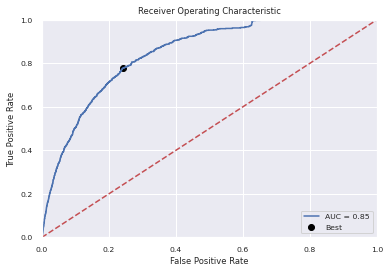

Best Threshold=0.004612, G-Mean=0.769


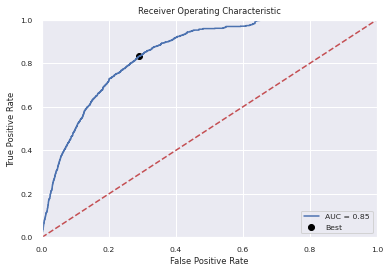

Best Threshold=0.006195, G-Mean=0.788


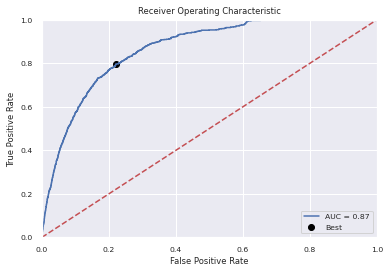

Best Threshold=0.003042, G-Mean=0.774


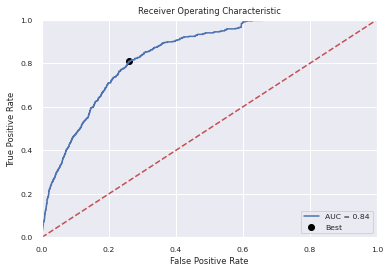

Best Threshold=0.015774, G-Mean=0.756


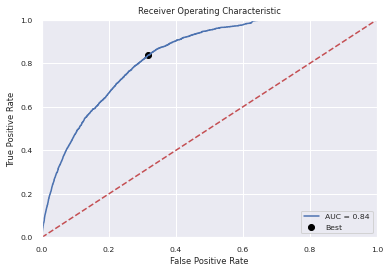

Best Threshold=0.003337, G-Mean=0.791


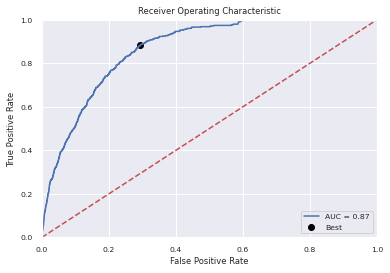

Best Threshold=0.006861, G-Mean=0.804


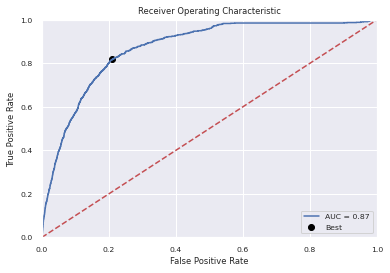

Best Threshold=0.004419, G-Mean=0.762


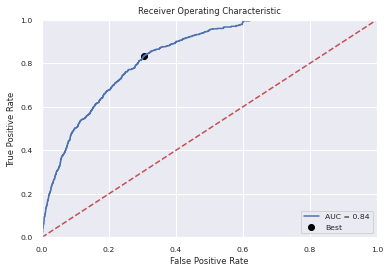

Best Threshold=0.004062, G-Mean=0.765


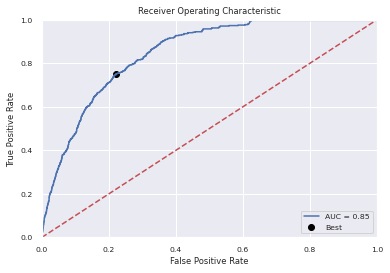

Best Threshold=0.005732, G-Mean=0.805


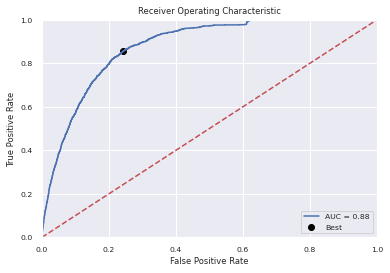

Best Threshold=0.005261, G-Mean=0.784


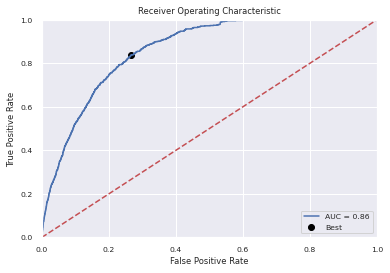

Best Threshold=0.004116, G-Mean=0.768


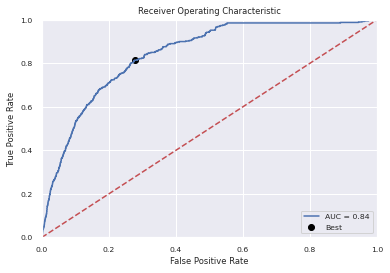

Best Threshold=0.004270, G-Mean=0.770


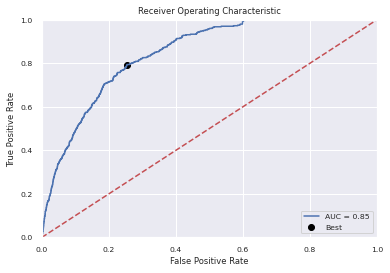

Best Threshold=0.039056, G-Mean=0.863


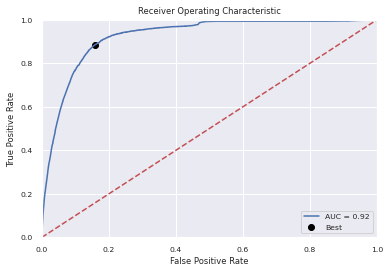

Best Threshold=0.005237, G-Mean=0.755


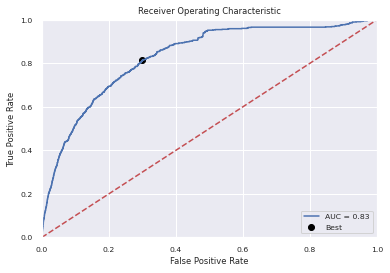

Best Threshold=0.004632, G-Mean=0.806


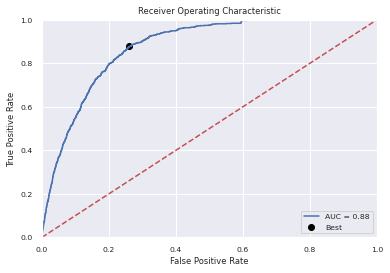

Best Threshold=0.006363, G-Mean=0.770


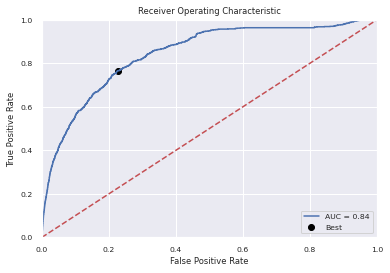

Best Threshold=0.017454, G-Mean=0.839


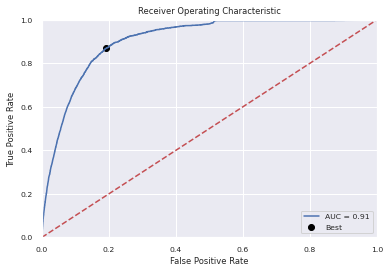

Best Threshold=0.010943, G-Mean=0.807


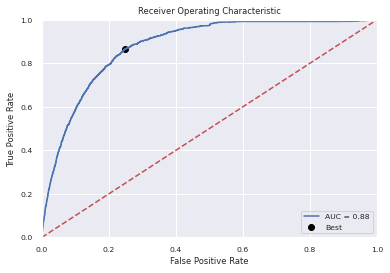

Best Threshold=0.011510, G-Mean=0.753


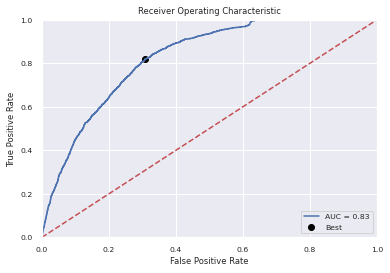

Best Threshold=0.005139, G-Mean=0.768


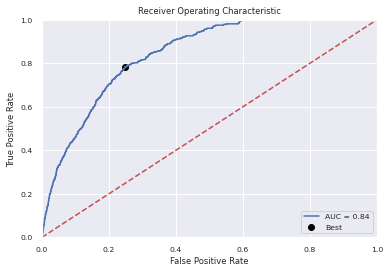

Best Threshold=0.006488, G-Mean=0.764


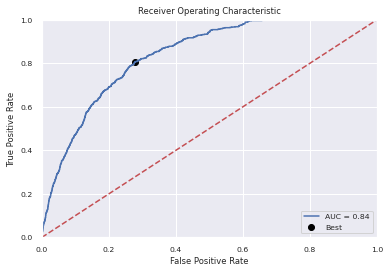

Best Threshold=0.012089, G-Mean=0.792


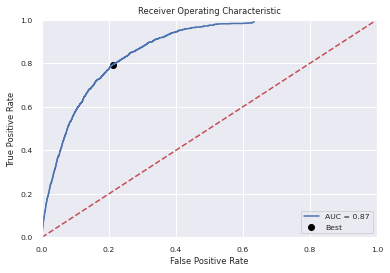

Best Threshold=0.003633, G-Mean=0.761


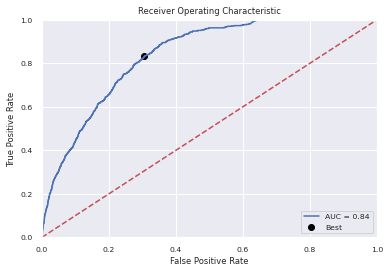

Best Threshold=0.020808, G-Mean=0.858


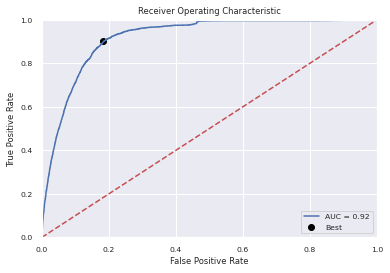

Best Threshold=0.004660, G-Mean=0.763


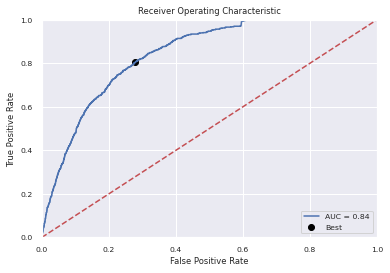

Best Threshold=0.016167, G-Mean=0.747


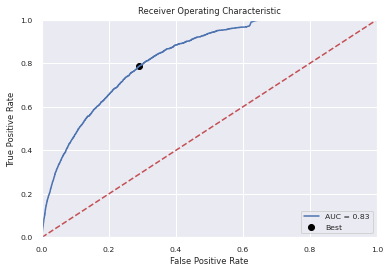

Best Threshold=0.007148, G-Mean=0.799


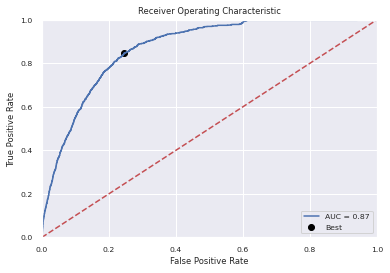

Best Threshold=0.005471, G-Mean=0.806


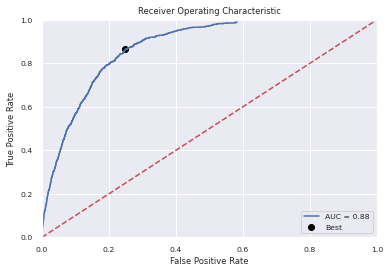

Best Threshold=0.009606, G-Mean=0.850


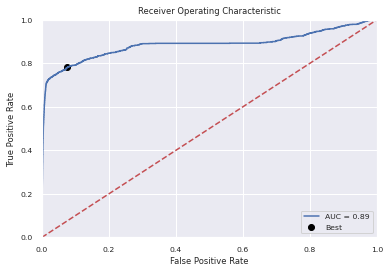

Best Threshold=0.002496, G-Mean=0.754


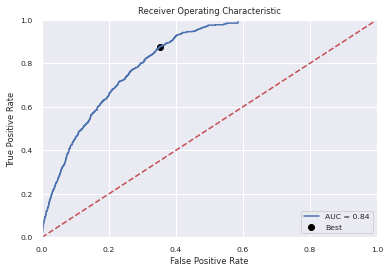

Best Threshold=0.004589, G-Mean=0.773


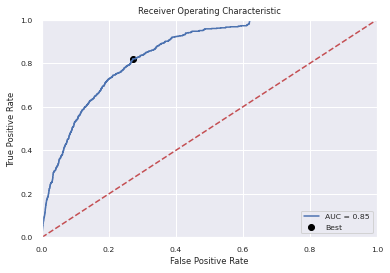

Best Threshold=0.009285, G-Mean=0.833


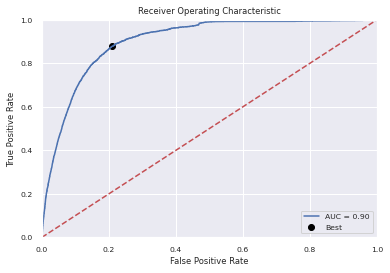

Best Threshold=0.010087, G-Mean=0.805


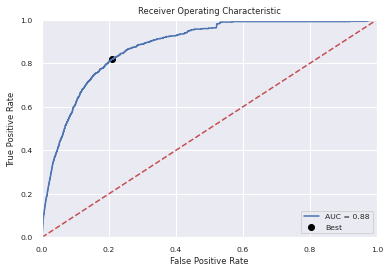

Best Threshold=0.003435, G-Mean=0.770


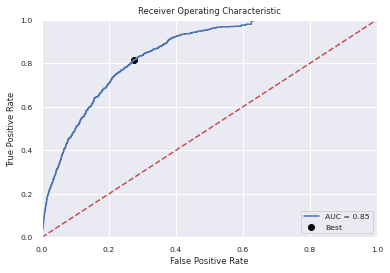

Best Threshold=0.004049, G-Mean=0.778


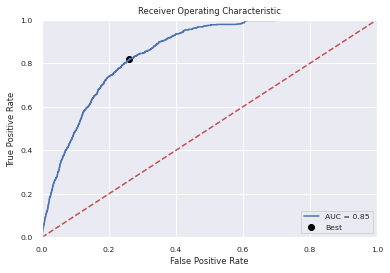

Best Threshold=0.006765, G-Mean=0.816


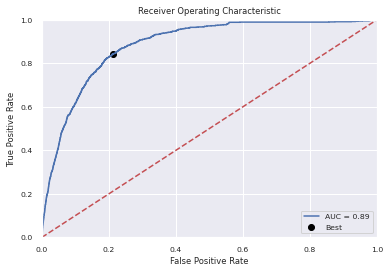

Best Threshold=0.002686, G-Mean=0.774


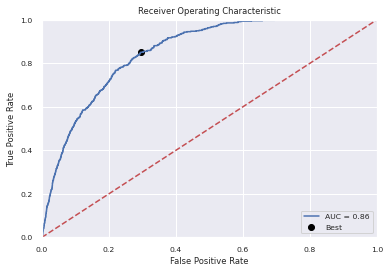

Best Threshold=0.004363, G-Mean=0.772


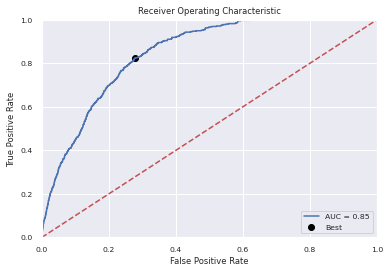

Best Threshold=0.008006, G-Mean=0.797


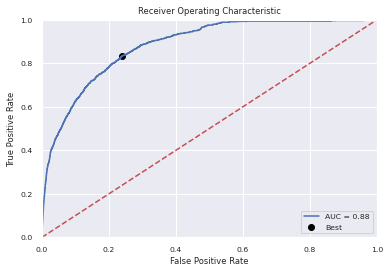

Best Threshold=0.008703, G-Mean=0.758


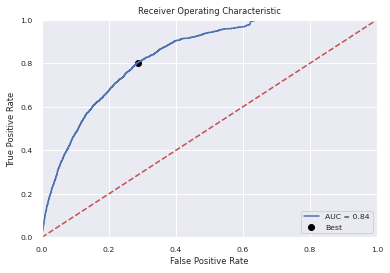

Best Threshold=0.002746, G-Mean=0.771


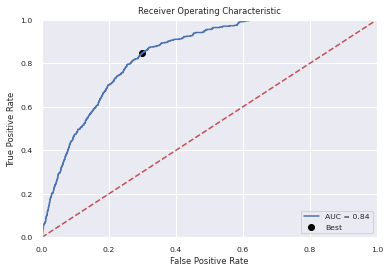

Best Threshold=0.005593, G-Mean=0.771


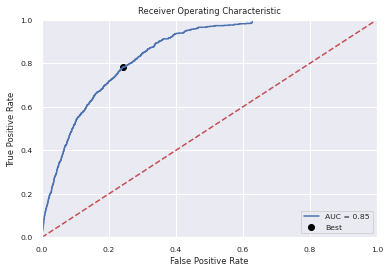

Best Threshold=0.008093, G-Mean=0.799


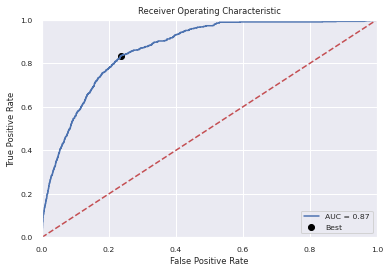

Best Threshold=0.006456, G-Mean=0.790


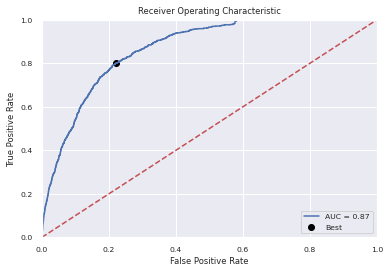

Best Threshold=0.006191, G-Mean=0.767


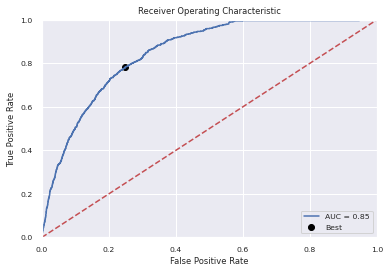

Best Threshold=0.006720, G-Mean=0.801


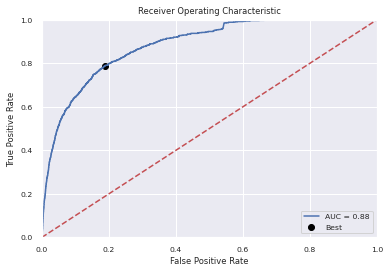

Best Threshold=0.005320, G-Mean=0.772


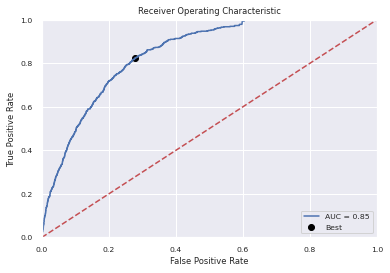

Best Threshold=0.002901, G-Mean=0.764


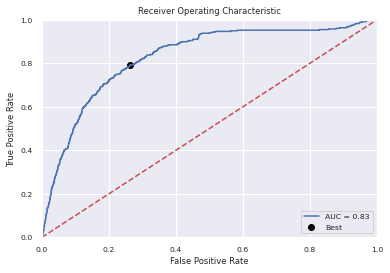

Best Threshold=0.005550, G-Mean=0.782


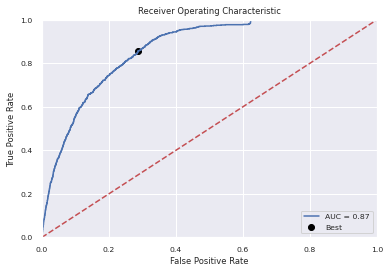

In [44]:
thresh = []
roc = []
for i in range(50):    
    import sklearn.metrics as metrics
    fpr, tpr, threshold = metrics.roc_curve(Y_test[:,i].numpy(), numpy_probas_test[:,i])
    roc_auc = metrics.auc(fpr, tpr)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = threshold[optimal_idx]
    roc.append(roc_auc)
    thresh.append(optimal_threshold)
    
    gmeans = np.sqrt(tpr * (1-fpr))
    ix = np.argmax(gmeans)
    print('Best Threshold=%f, G-Mean=%.3f' % (threshold[ix], gmeans[ix]))

    # method I: plt
    import matplotlib.pyplot as plt
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [45]:
sum(roc)/50

0.8596500067778436

In [46]:
def to_labels(pos_probs, threshold):
	return (pos_probs >= threshold).astype('int')

for i in range(50):
    numpy_probas_test[:,i] = to_labels(numpy_probas_test[:,i],thresh[i])

In [47]:
scores = []
for i in range(50):
    scores.append(binary_classification_performance(Y_test[:,i].numpy(),numpy_probas_test[:,i]))

In [48]:
f = pd.concat(scores)

In [49]:
f.mean(axis=0)

Accuracy                          0.7316
Precision (or PPV)                0.0394
Recall (senitivity or TPR)        0.8438
f1 score                          0.0720
Specificty (or TNR)               0.0394
NPV                               0.8438
True Positive                 77365.8200
True Negative                   987.3400
False Positive                28497.4600
False Negative                  166.3800
dtype: float64

In [50]:
from sklearn.metrics import multilabel_confusion_matrix
multilabel_confusion_matrix(Y_test.numpy(), numpy_probas_test)

array([[[ 77579,  28525],
        [   177,    736]],

       [[ 73804,  32491],
        [   108,    614]],

       [[ 82697,  23501],
        [   166,    653]],

       [[ 78917,  27665],
        [    83,    352]],

       [[ 68898,  35572],
        [   349,   2198]],

       [[ 75183,  31324],
        [    58,    452]],

       [[ 83805,  22251],
        [   174,    787]],

       [[ 71722,  34687],
        [    87,    521]],

       [[ 68819,  37741],
        [    47,    410]],

       [[ 79513,  26117],
        [   192,   1195]],

       [[ 77896,  28353],
        [   124,    644]],

       [[ 77116,  29480],
        [    78,    343]],

       [[ 79530,  27078],
        [    84,    325]],

       [[ 82159,  17540],
        [   701,   6617]],

       [[ 74335,  31967],
        [   132,    583]],

       [[ 78503,  27685],
        [   101,    728]],

       [[ 82095,  23981],
        [   220,    721]],

       [[ 81795,  21875],
        [   367,   2980]],

       [[ 79067,  26185],
  

# Binary Logits

In [51]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [52]:
#Converting engagement frequencies from tensor to numpy array

X_freq_1 = X_freq.numpy()
X_freq_1_test = X_freq_test.numpy()


In [53]:
empty_train_p = []
empty_test_p = []
for i in range(50):
    recent_lm_train = X_recent_2[:,[i,i+50,i+100,i+150]]     #Engagement history by topic as input for training
    freq_lm_train = X_freq_1[:,i]                            #Engagement frequncy by topic as input for training
    recommend_lm_train = X_recommend_1[:,i]                  #Recommendations by topic as input for training
    
    recent_lm_test = X_recent_2_test[:,[i,i+50,i+100,i+150]] #Engagement history by topic as input for testing
    freq_lm_test = X_freq_1_test[:,i]                        #Engagement frequncy by topic as input for testing
    recommend_lm_test = X_recommend_t[:,i]                   #Recommendations by topic as input for testing


    y_lm_train = y_1[:,i]                                    #Engagement labels

    X = np.column_stack([recent_lm_train,freq_lm_train,recommend_lm_train])  #Concatenated input features for training

    #LR = LogisticRegression(class_weight="balanced")
    LR = LogisticRegression()

    LR.fit(X,y_lm_train)
    
    X_test = np.column_stack([recent_lm_test,freq_lm_test,recommend_lm_test]) #Concatenated input features for testing
    
    empty_train_p.append((LR.predict_proba(X)[:,1]))
       
    empty_test_p.append((LR.predict_proba(X_test)[:,1]))
      

In [54]:
prediction_lr_train_p = np.transpose(np.array(empty_train_p))  #Predictions for training data
prediction_lr_test_p = np.transpose(np.array(empty_test_p))    #Predictions for test data

In [55]:
from sklearn.metrics import log_loss
log_loss(y_t,prediction_lr_test_p)

1.8135723806680297

Best Threshold=0.008881, G-Mean=0.966


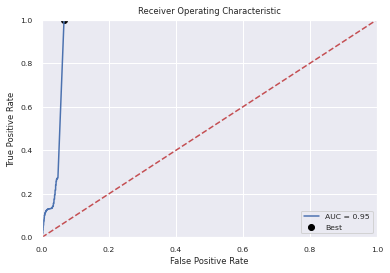

Best Threshold=0.006259, G-Mean=0.973


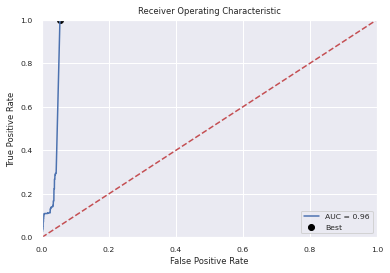

Best Threshold=0.007166, G-Mean=0.973


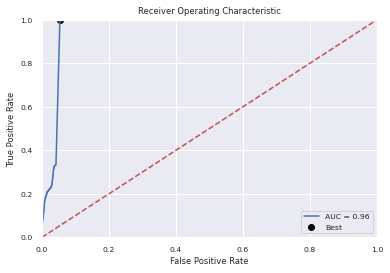

Best Threshold=0.003187, G-Mean=0.977


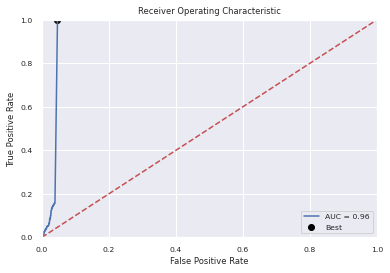

Best Threshold=0.016084, G-Mean=0.877


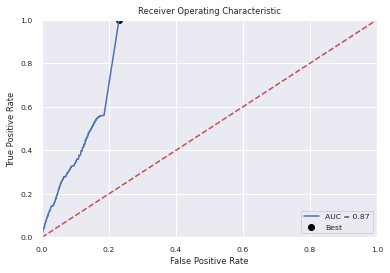

Best Threshold=0.004598, G-Mean=0.975


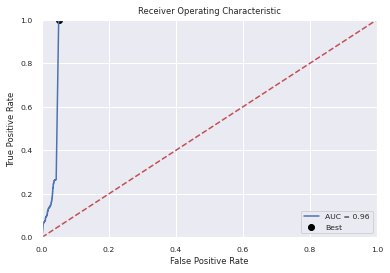

Best Threshold=0.008960, G-Mean=0.979


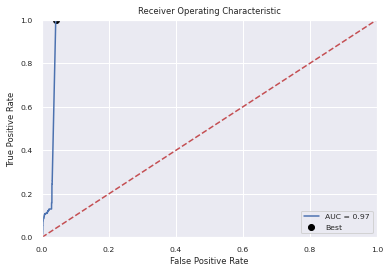

Best Threshold=0.006010, G-Mean=0.979


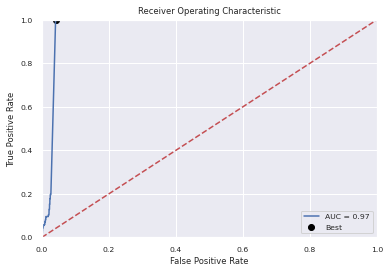

Best Threshold=0.003978, G-Mean=0.973


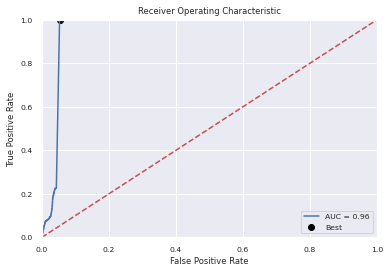

Best Threshold=0.006785, G-Mean=0.973


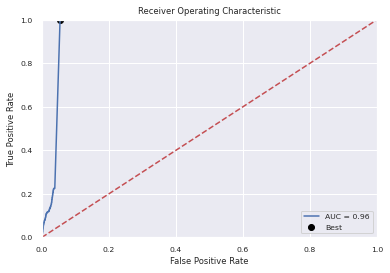

Best Threshold=0.006264, G-Mean=0.965


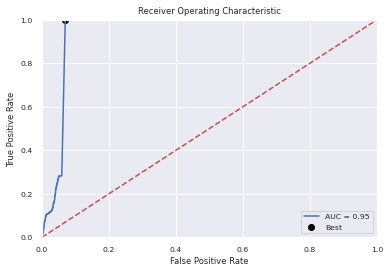

Best Threshold=0.004572, G-Mean=0.975


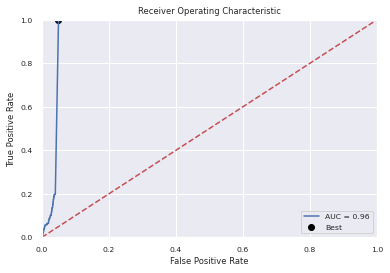

Best Threshold=0.005817, G-Mean=0.981


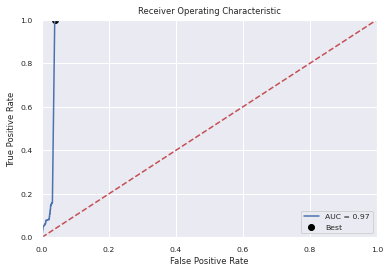

Best Threshold=0.024027, G-Mean=0.890


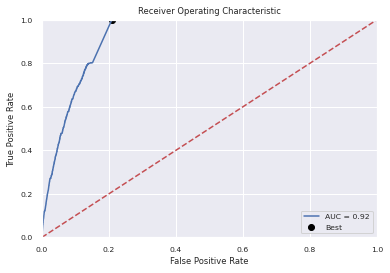

Best Threshold=0.007566, G-Mean=0.964


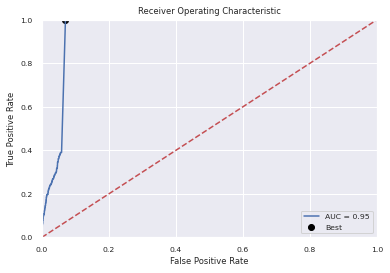

Best Threshold=0.005521, G-Mean=0.954


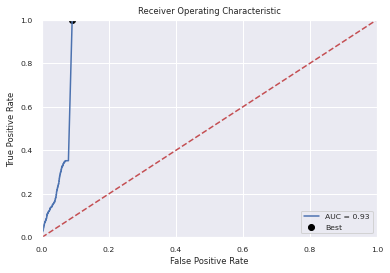

Best Threshold=0.006540, G-Mean=0.945


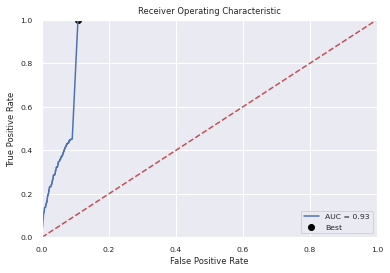

Best Threshold=0.015913, G-Mean=0.912


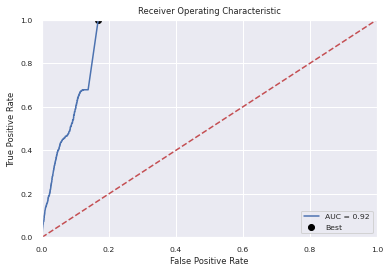

Best Threshold=0.011180, G-Mean=0.934


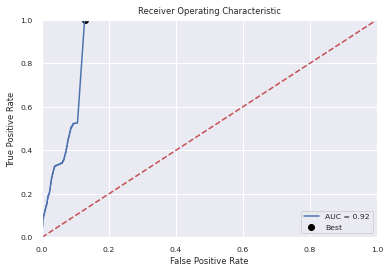

Best Threshold=0.012391, G-Mean=0.936


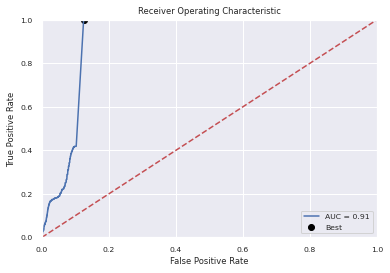

Best Threshold=0.005452, G-Mean=0.974


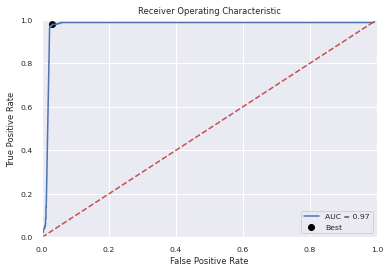

Best Threshold=0.008711, G-Mean=0.974


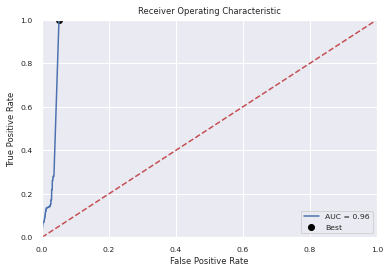

Best Threshold=0.010566, G-Mean=0.946


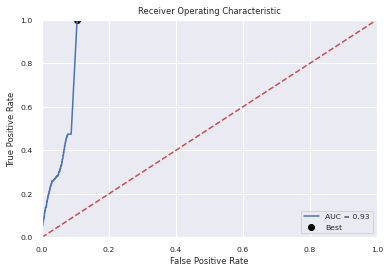

Best Threshold=0.005802, G-Mean=0.978


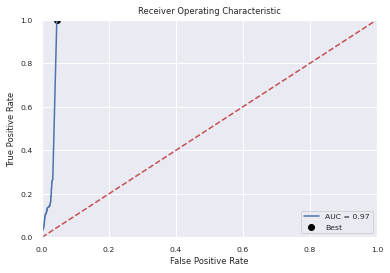

Best Threshold=0.012802, G-Mean=0.896


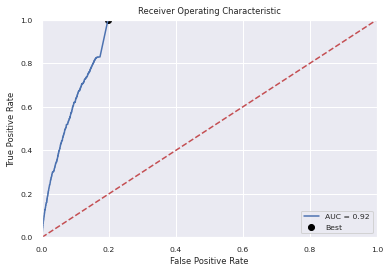

Best Threshold=0.004758, G-Mean=0.942


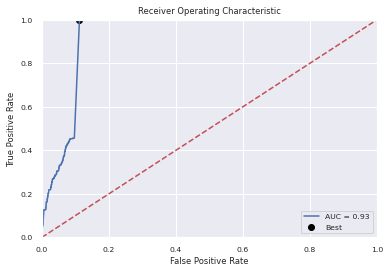

Best Threshold=0.015143, G-Mean=0.882


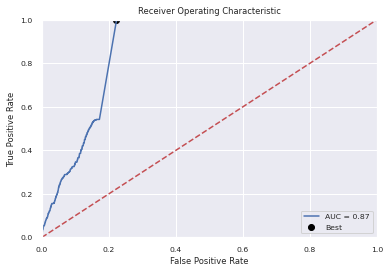

Best Threshold=0.008100, G-Mean=0.962


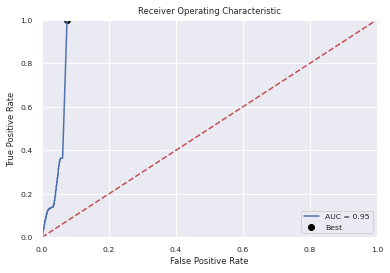

Best Threshold=0.006562, G-Mean=0.969


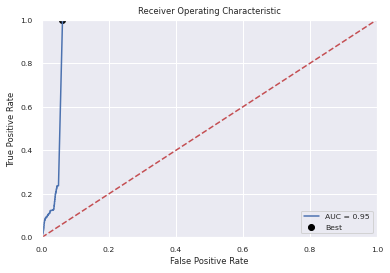

Best Threshold=0.002831, G-Mean=0.969


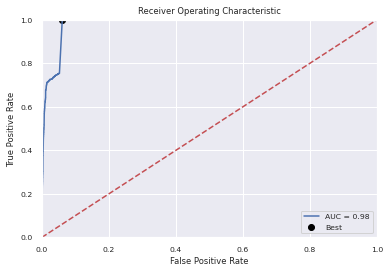

Best Threshold=0.003794, G-Mean=0.975


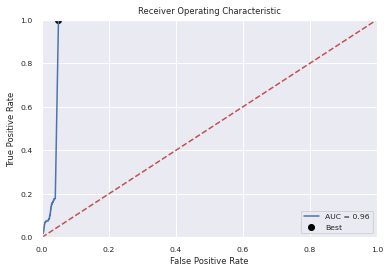

Best Threshold=0.006649, G-Mean=0.980


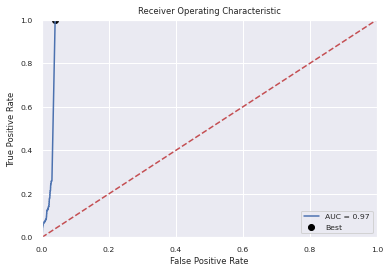

Best Threshold=0.009130, G-Mean=0.917


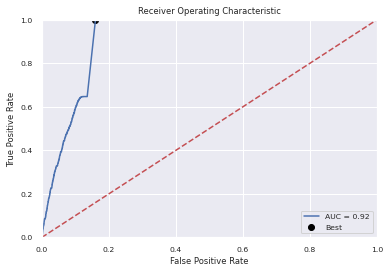

Best Threshold=0.011429, G-Mean=0.968


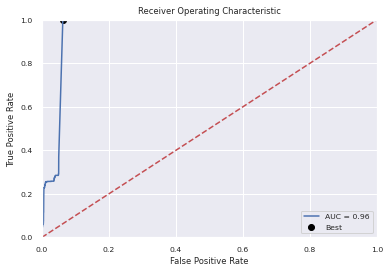

Best Threshold=0.004108, G-Mean=0.975


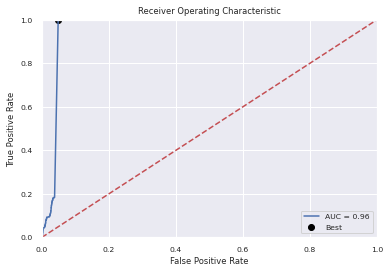

Best Threshold=0.005948, G-Mean=0.981


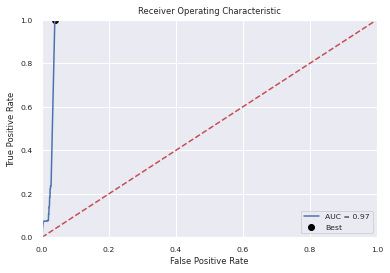

Best Threshold=0.007821, G-Mean=0.954


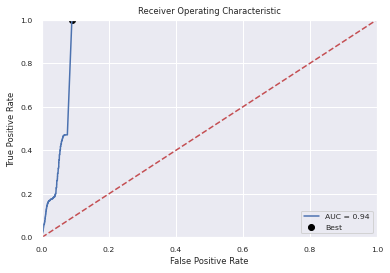

Best Threshold=0.003965, G-Mean=0.983


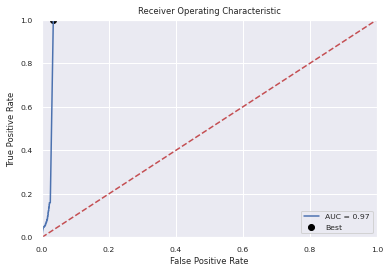

Best Threshold=0.005493, G-Mean=0.978


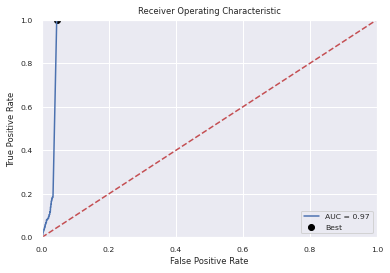

Best Threshold=0.005798, G-Mean=0.949


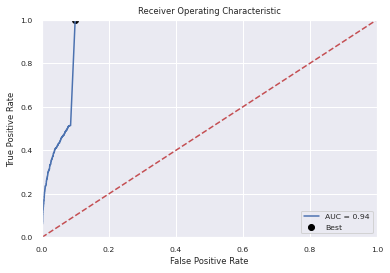

Best Threshold=0.011456, G-Mean=0.952


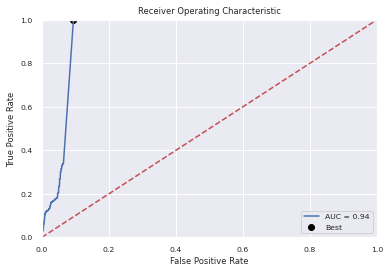

Best Threshold=0.004750, G-Mean=0.984


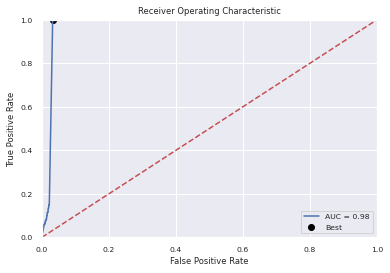

Best Threshold=0.006533, G-Mean=0.975


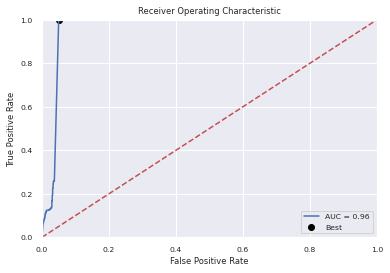

Best Threshold=0.009771, G-Mean=0.961


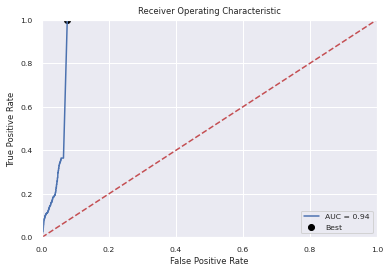

Best Threshold=0.007426, G-Mean=0.969


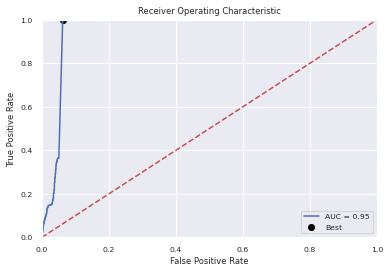

Best Threshold=0.007805, G-Mean=0.972


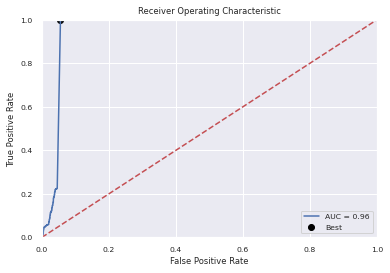

Best Threshold=0.004889, G-Mean=0.958


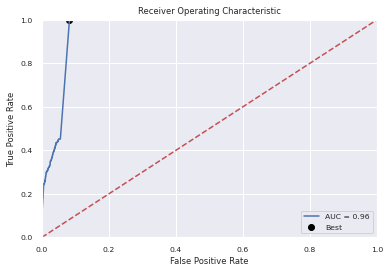

Best Threshold=0.008410, G-Mean=0.986


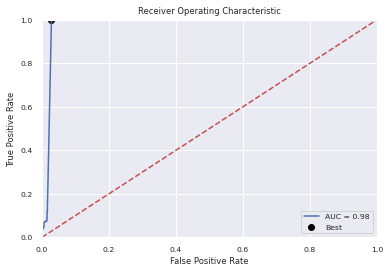

Best Threshold=0.005163, G-Mean=0.988


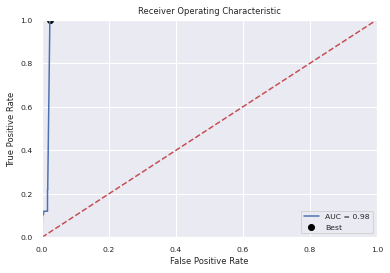

Best Threshold=0.006478, G-Mean=0.966


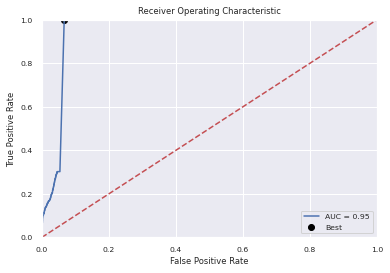

In [56]:
thresh_lr = []
roc_lr = []
for i in range(50):    
    import sklearn.metrics as metrics
    fpr, tpr, threshold = metrics.roc_curve(Y_test[:,i].numpy(), prediction_lr_test_p[:,i])
    roc_auc = metrics.auc(fpr, tpr)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = threshold[optimal_idx]
    thresh_lr.append(optimal_threshold)
    roc_lr.append(roc_auc)
    
    gmeans = np.sqrt(tpr * (1-fpr))
    ix = np.argmax(gmeans)
    print('Best Threshold=%f, G-Mean=%.3f' % (threshold[ix], gmeans[ix]))

    # method I: plt
    import matplotlib.pyplot as plt
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show() 

In [57]:
sum(roc_lr)/50  #Average AUC-ROC score 

0.9497445073771786

In [58]:
prediction_lr_test_p.shape

(107017, 50)

In [59]:
label_lr_test_p = np.empty([107017, 50])
for i in range(50):
    label_lr_test_p[:,i] = to_labels(prediction_lr_test_p[:,i],thresh_lr[i])

In [60]:
from sklearn.metrics import multilabel_confusion_matrix
multilabel_confusion_matrix(Y_test.numpy(), label_lr_test_p)


array([[[ 99114,   6990],
        [     0,    913]],

       [[100608,   5687],
        [     0,    722]],

       [[100512,   5686],
        [     0,    819]],

       [[101669,   4913],
        [     0,    435]],

       [[ 80422,  24048],
        [     0,   2547]],

       [[101221,   5286],
        [     0,    510]],

       [[101687,   4369],
        [     0,    961]],

       [[102071,   4338],
        [     0,    608]],

       [[100946,   5614],
        [     0,    457]],

       [[ 99920,   5710],
        [     0,   1387]],

       [[ 98881,   7368],
        [     0,    768]],

       [[101354,   5242],
        [     0,    421]],

       [[102547,   4061],
        [     0,    409]],

       [[ 78935,  20764],
        [     0,   7318]],

       [[ 98851,   7451],
        [     0,    715]],

       [[ 96638,   9550],
        [     0,    829]],

       [[ 94694,  11382],
        [     0,    941]],

       [[ 86276,  17394],
        [     0,   3347]],

       [[ 91868,  13384],
  

In [61]:
scores_lr = []
for i in range(50):
    scores_lr.append(binary_classification_performance(Y_test[:,i].numpy(),label_lr_test_p[:,i]))

In [62]:
f_lr = pd.concat(scores_lr)

In [63]:
f_lr.mean(axis=0)

Accuracy                          0.9230
Precision (or PPV)                0.1172
Recall (senitivity or TPR)        0.9996
f1 score                          0.2086
Specificty (or TNR)               0.1172
NPV                               0.9996
True Positive                 97588.9400
True Negative                  1153.5200
False Positive                 8274.3400
False Negative                    0.2000
dtype: float64

# Light GBM model

In [64]:
!pip install lightgbm

In [65]:
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier



In [66]:
empty_train_1p = []
empty_test_1p = []


for i in range(50):
    recent_lm_train = X_recent_2[:,[i,i+50,i+100,i+150]]
    freq_lm_train = X_freq_1[:,i]
    recommend_lm_train = X_recommend_1[:,i]
    
    recent_lm_test = X_recent_2_test[:,[i,i+50,i+100,i+150]]
    freq_lm_test = X_freq_1_test[:,i]
    recommend_lm_test = X_recommend_t[:,i]


    y_lm_train = y_1[:,i]
    

    X = np.column_stack([recent_lm_train,freq_lm_train,recommend_lm_train])

    LGBM = LGBMClassifier()

    LGBM.fit(X,y_lm_train)
    
    X_test = np.column_stack([recent_lm_test,freq_lm_test,recommend_lm_test])
    
    empty_train_1p.append((LGBM.predict_proba(X)[:,1]))

    empty_test_1p.append((LGBM.predict_proba(X_test)[:,1]))
        


In [67]:
prediction_lgbm_train_p = np.transpose(np.array(empty_train_1p))
prediction_lgbm_test_p = np.transpose(np.array(empty_test_1p))

In [68]:
from sklearn.metrics import log_loss
log_loss(Y_test.numpy(),prediction_lgbm_test_p)

2.1110753434129164

0.006000827529146676
Best Threshold=0.006001, G-Mean=0.407


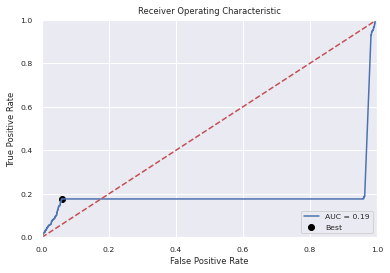

0.004042194310026697
Best Threshold=0.004042, G-Mean=0.374


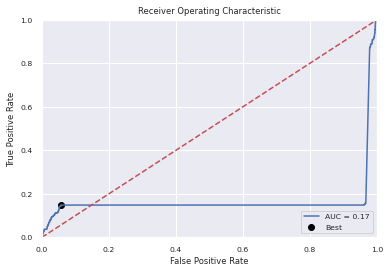

0.004413175530889279
Best Threshold=0.004413, G-Mean=0.951


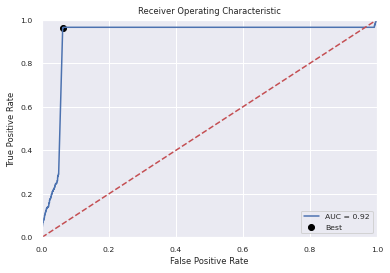

1.68625631200719e-06
Best Threshold=0.001388, G-Mean=0.154


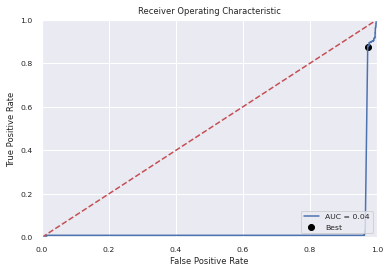

0.010352783956124927
Best Threshold=0.010353, G-Mean=0.663


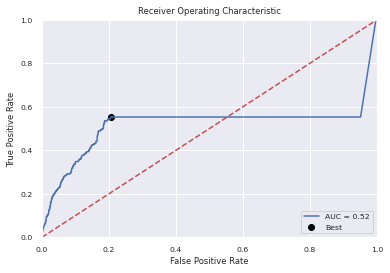

0.0031144703490700643
Best Threshold=0.003114, G-Mean=0.421


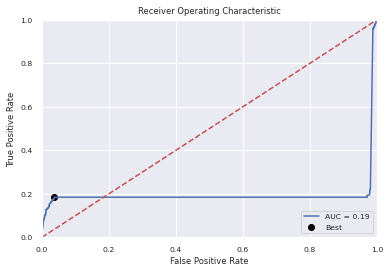

0.00525795958691404
Best Threshold=0.005258, G-Mean=0.960


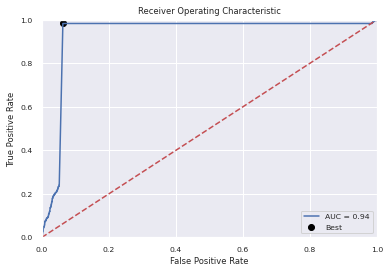

0.023398741334425974
Best Threshold=0.005179, G-Mean=0.139


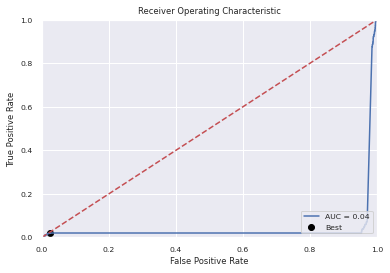

0.00324238354600167
Best Threshold=0.003242, G-Mean=0.917


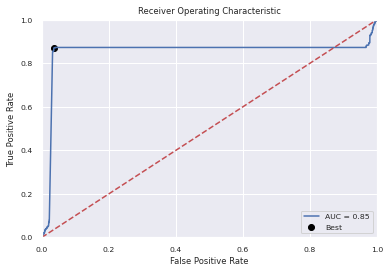

0.00414875988325936
Best Threshold=0.004149, G-Mean=0.939


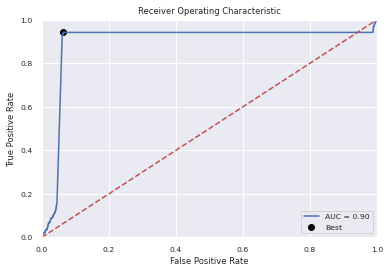

0.004824467247620627
Best Threshold=0.004824, G-Mean=0.230


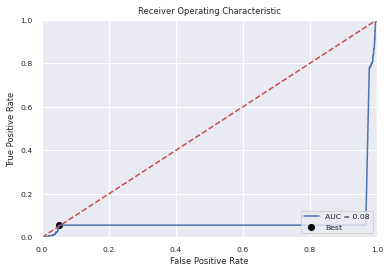

0.0039577989482904195
Best Threshold=0.003958, G-Mean=0.951


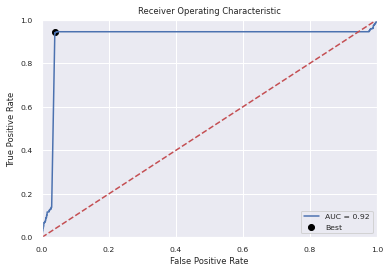

0.003752764789196015
Best Threshold=0.003753, G-Mean=0.333


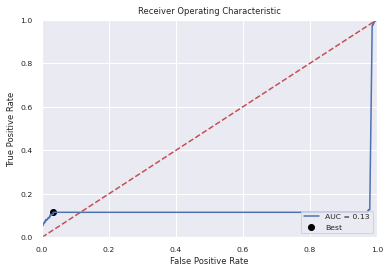

0.014080381378376533
Best Threshold=0.014080, G-Mean=0.889


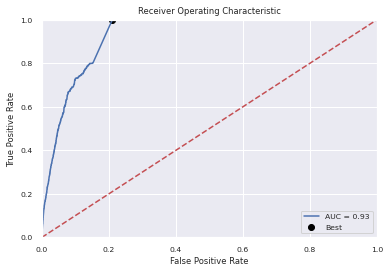

0.0043797666249017955
Best Threshold=0.004380, G-Mean=0.941


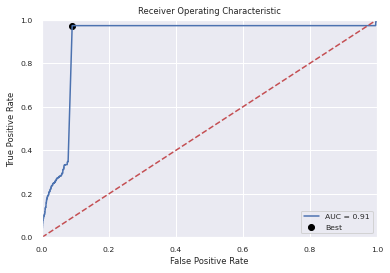

0.0035422852421033517
Best Threshold=0.003542, G-Mean=0.457


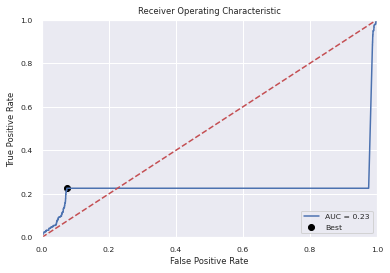

0.0038430501331464828
Best Threshold=0.003843, G-Mean=0.935


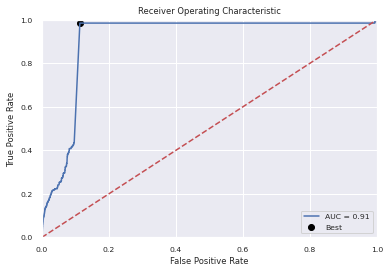

0.008117118514360139
Best Threshold=0.008117, G-Mean=0.908


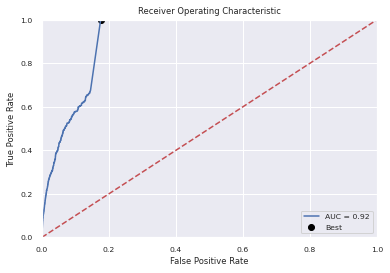

0.0070058337421298675
Best Threshold=0.007006, G-Mean=0.671


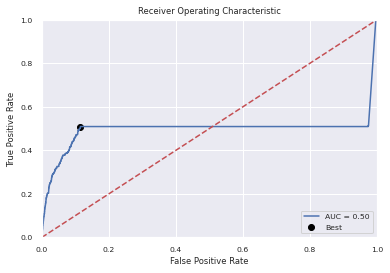

0.007722728891108593
Best Threshold=0.007723, G-Mean=0.591


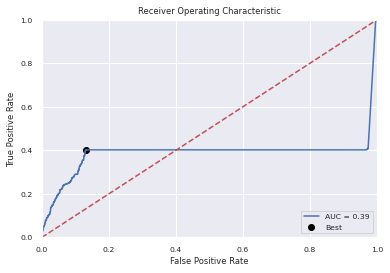

0.0059958511428864145
Best Threshold=0.005996, G-Mean=0.313


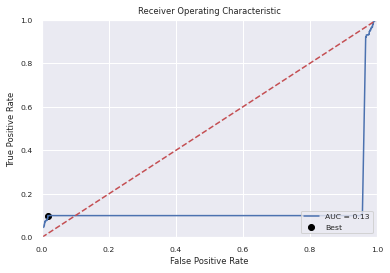

0.005678311122657699
Best Threshold=0.005678, G-Mean=0.455


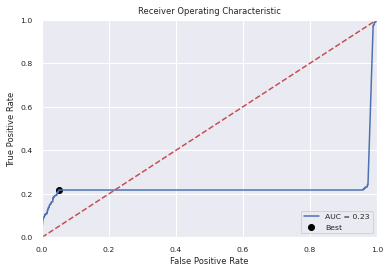

0.005910195014111901
Best Threshold=0.005910, G-Mean=0.644


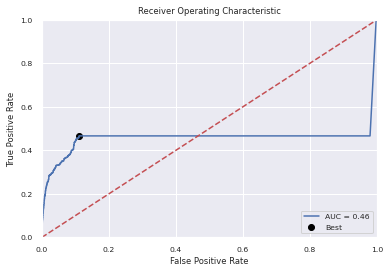

0.0032222632187032013
Best Threshold=0.003222, G-Mean=0.434


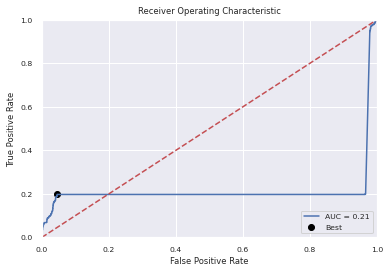

0.006635325519777109
Best Threshold=0.006635, G-Mean=0.896


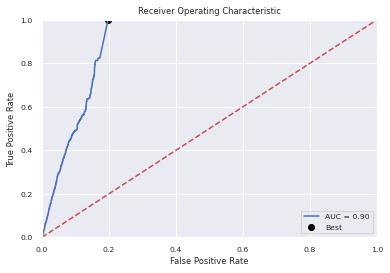

0.0030662952364611216
Best Threshold=0.003066, G-Mean=0.556


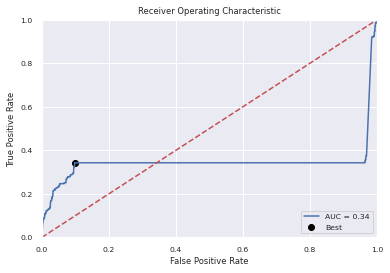

0.00986966472512499
Best Threshold=0.009870, G-Mean=0.637


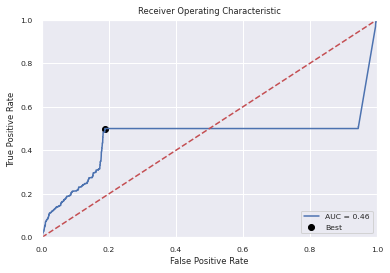

0.005164576013261374
Best Threshold=0.005165, G-Mean=0.901


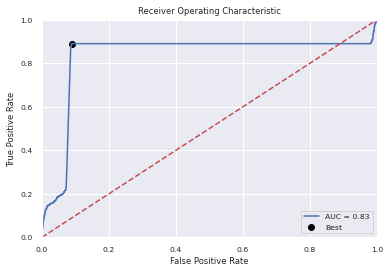

0.005187065523835825
Best Threshold=0.004631, G-Mean=0.335


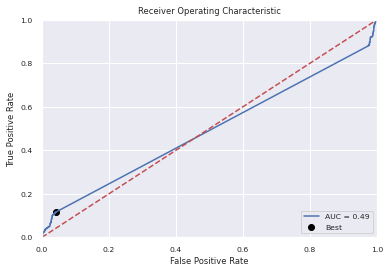

0.0024281590687420802
Best Threshold=0.002428, G-Mean=0.965


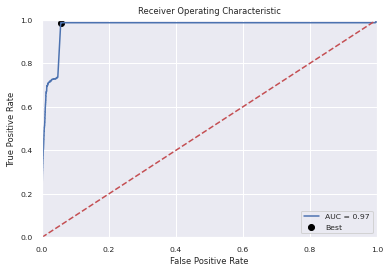

0.0028819696454877304
Best Threshold=0.002882, G-Mean=0.210


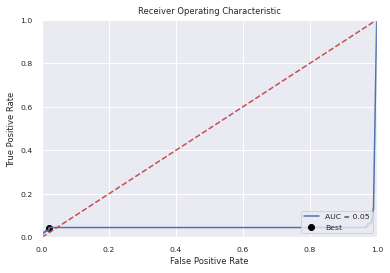

0.004041835305695593
Best Threshold=0.004042, G-Mean=0.363


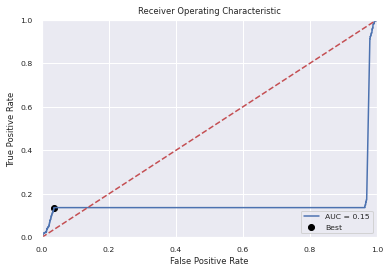

0.005017022641410997
Best Threshold=0.005017, G-Mean=0.913


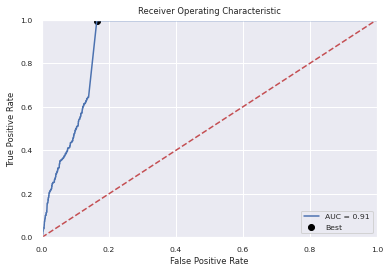

0.006689694537004804
Best Threshold=0.006690, G-Mean=0.538


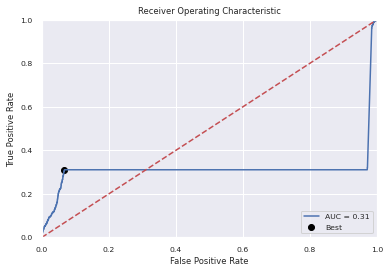

0.003260016370256503
Best Threshold=0.003260, G-Mean=0.222


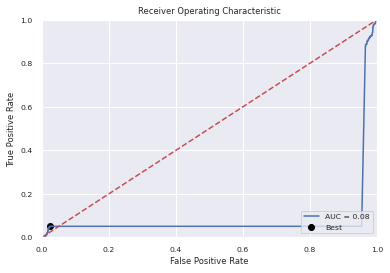

0.0035927650480338156
Best Threshold=0.003593, G-Mean=0.352


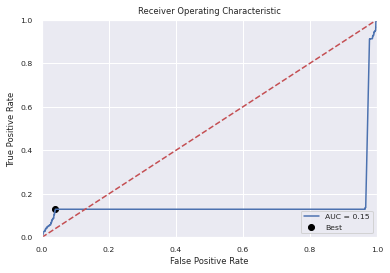

0.00433319367017322
Best Threshold=0.004333, G-Mean=0.610


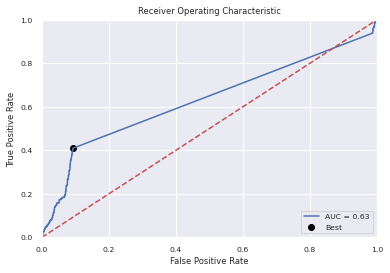

0.00258034579369733
Best Threshold=0.002088, G-Mean=0.169


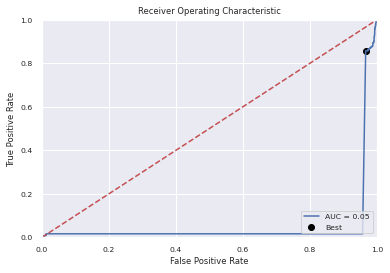

0.009711395334617592
Best Threshold=0.004484, G-Mean=0.230


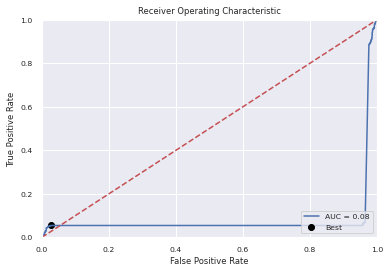

0.004731242084834546
Best Threshold=0.004731, G-Mean=0.946


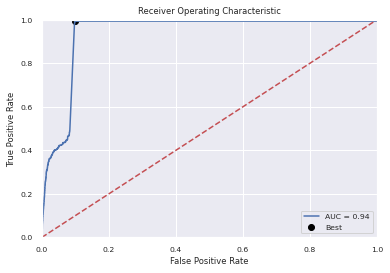

0.006776357273558785
Best Threshold=0.006776, G-Mean=0.514


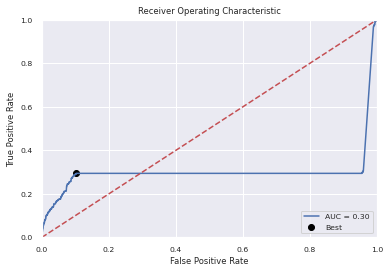

7.525579379425184e-06
Best Threshold=0.001946, G-Mean=0.153


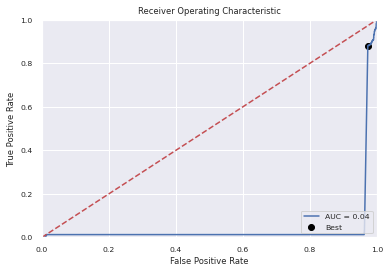

0.004134404179490661
Best Threshold=0.004134, G-Mean=0.408


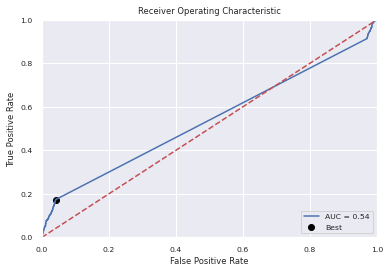

0.005932805038813639
Best Threshold=0.005933, G-Mean=0.530


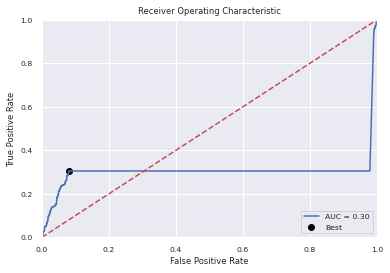

0.005251819780859921
Best Threshold=0.005252, G-Mean=0.462


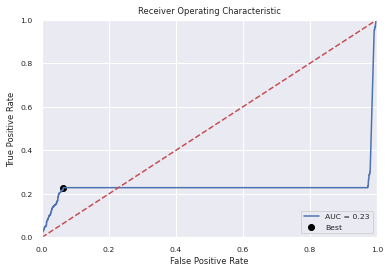

0.005835924748840566
Best Threshold=0.005836, G-Mean=0.309


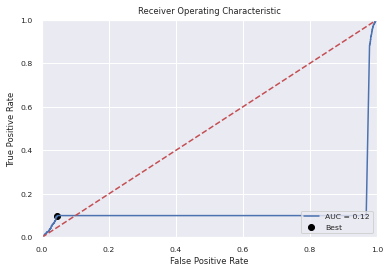

0.0035284463296073663
Best Threshold=0.003528, G-Mean=0.920


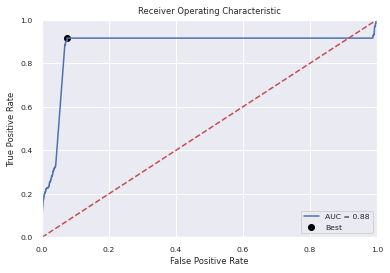

0.0053410695524510774
Best Threshold=0.005341, G-Mean=0.293


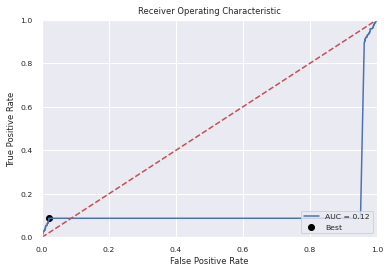

0.002776723267510354
Best Threshold=0.002777, G-Mean=0.951


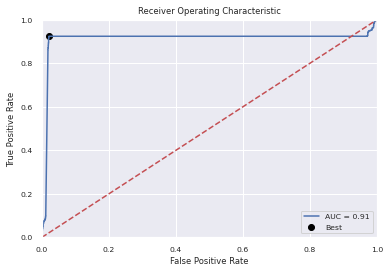

0.00458551384499411
Best Threshold=0.004586, G-Mean=0.947


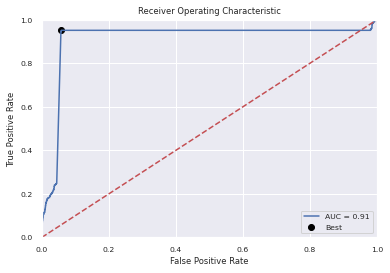

In [69]:
thresh_lgbm = []
roc_lgbm = []
for i in range(50):    
    import sklearn.metrics as metrics
    # calculate the fpr and tpr for all thresholds of the classification
    #probs = model.predict_proba(X_test)
    #preds = probs[:,1]
    fpr, tpr, threshold = metrics.roc_curve(Y_test[:,i].numpy(), prediction_lgbm_test_p[:,i])
    roc_auc = metrics.auc(fpr, tpr)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = threshold[optimal_idx]
    print(optimal_threshold)
    thresh_lgbm.append(optimal_threshold)
    roc_lgbm.append(roc_auc)
    
    gmeans = np.sqrt(tpr * (1-fpr))
    ix = np.argmax(gmeans)
    print('Best Threshold=%f, G-Mean=%.3f' % (threshold[ix], gmeans[ix]))

    # method I: plt
    import matplotlib.pyplot as plt
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show() 

In [70]:
sum(roc_lgbm)/50

0.46802854938485444

In [71]:
label_lgbm_test_p = np.empty([107017, 50])
for i in range(50):
    label_lgbm_test_p[:,i] = to_labels(prediction_lgbm_test_p[:,i],thresh_lgbm[i])

In [72]:
multilabel_confusion_matrix(Y_test.numpy(), label_lgbm_test_p)

array([[[ 99800,   6304],
        [   752,    161]],

       [[100249,   6046],
        [   615,    107]],

       [[ 99574,   6624],
        [    29,    790]],

       [[    79, 106503],
        [     0,    435]],

       [[ 83006,  21464],
        [  1138,   1409]],

       [[102601,   3906],
        [   416,     94]],

       [[ 99454,   6602],
        [    16,    945]],

       [[105388,   1021],
        [   601,      7]],

       [[102810,   3750],
        [    59,    398]],

       [[ 98864,   6766],
        [    80,   1307]],

       [[100821,   5428],
        [   725,     43]],

       [[102285,   4311],
        [    24,    397]],

       [[103026,   3582],
        [   362,     47]],

       [[ 78801,  20898],
        [     8,   7310]],

       [[ 96729,   9573],
        [    19,    696]],

       [[ 98287,   7901],
        [   642,    187]],

       [[ 94072,  12004],
        [    14,    927]],

       [[ 85521,  18149],
        [     5,   3342]],

       [[ 93172,  12080],
  

In [73]:
scores_lgbm = []
for i in range(50):
    scores_lgbm.append(binary_classification_performance(Y_test[:,i].numpy(),label_lgbm_test_p[:,i]))

In [74]:
f_lgbm = pd.concat(scores_lgbm)

In [75]:
f_lgbm.mean(axis=0)

Accuracy                          0.8848
Precision (or PPV)                0.0600
Recall (senitivity or TPR)        0.4992
f1 score                          0.1052
Specificty (or TNR)               0.0600
NPV                               0.4992
True Positive                 94038.9000
True Negative                   739.4000
False Positive                11824.3800
False Negative                  414.3200
dtype: float64

# Exhaustive search for Optimization

In [76]:
x = pd.DataFrame(X_recommend_t)
x.sum(axis=1).value_counts()
x['Total'] = x.sum(axis=1)
y=x[x['Total'] >= 6] #Considering only the users who are shown atleast six tweets
#del y['Total']

infinity = pd.DataFrame(X_freq_1_test)
histo = pd.DataFrame(X_recent_2_test)

inf_new=infinity.loc[y.index,:]
hist_new=histo.loc[y.index,:]

In [77]:

def dfs(x,start,end,cnt,l_):
    if start==end:
        return []
    if cnt==5:
        ans.append(l_)
        return 
    
    for i in range(start,end):
        if int(x[i])==1:           
            dfs(x,i+1,end,cnt+1,l_+[i])
                    
d={}
cnt={}
v={}
for i in y.index:
    p=y.loc[i,:]
    l=list(p)
    ans=[]
    dfs(l,0,len(l),0,[])

    v[i]=ans
    for m in range(len(ans)):
        n=[0]*50
        for k in range(len(ans[m])):
            n[ans[m][k]]=1
        if i not in d:
            d[i]=[]
        d[i].append(n)


In [78]:
global_l=[]    
for i in d:
    for x in d[i]:
        global_l.append([i]+x)

#Dataframe enumerating all the possible recommendation scenarios for all the users.
global_df=pd.DataFrame(global_l,columns=['User']+[i for i in range(50)]).set_index('User')         

In [79]:
opt_rec = global_df 
opt_freq =inf_new.loc[global_df.index]   
opt_hist = hist_new.loc[global_df.index]

In [80]:
#Converting all the dataframes to tensors.
opt_freq_T = torch.FloatTensor(opt_freq.values)
opt_hist_T = torch.FloatTensor(opt_hist.values.reshape(-1,50,4))
opt_rec_T = torch.FloatTensor(opt_rec.values)
opt_indicator_T = torch.ones([505809, 50])

In [81]:
test_dataset = TensorDataset(opt_freq_T, opt_hist_T, opt_rec_T, opt_indicator_T)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle = False)

In [82]:
probas_opt = []
import time
start_time = time.time()
counter = 0

for step_num, batch_data in enumerate(test_dataloader):
        freq, recent, recommend, indicator = tuple(t.to(device)for t in batch_data)
        logits_opt = model(freq, recent, recommend, indicator)
        numpy_logits_opt = logits_opt.to('cpu').detach().numpy()
        numpy_probas_opt = sigmoid_v(numpy_logits_opt)
        probas_opt.append(pd.DataFrame(numpy_probas_opt).round(decimals=6))
        counter = counter + 1
print(counter)        
print("--- %s seconds ---" % (time.time() - start_time)) 

15807
--- 116.98815536499023 seconds ---


In [83]:
fins = pd.concat(probas_opt)
fins = fins*opt_rec.values

In [84]:
scor = pd.DataFrame()
scor['total'] = fins.sum(axis = 1)
scor['user'] = global_df.index
scor.index = global_df.index

In [85]:
opt_rec_T_F = global_df
opt_rec_T_F['prob'] = scor['total']
opt_rec_T_F['ind'] = scor['user']
lp = opt_rec_T_F.sort_values('prob', ascending=False).drop_duplicates(['ind'])
mp= lp.reindex(y.index)

In [86]:
mp['prob'].mean()

0.3512265819881041

In [87]:
#del lp['prob']
#del lp['ind']

In [88]:
lr_p = pd.DataFrame(prediction_lgbm_test_p)
lr_ding = lr_p.loc[y.index]
p=lr_ding*y.iloc[:,0:50].values


In [89]:
s=pd.DataFrame(np.zeros((p.shape[0],p.shape[1]))).set_index(p.index)
for ind in p.index:
    s.loc[ind,p.loc[ind].nlargest(5).index.values]=1
s_=s.reset_index() 

In [90]:
opt_rec_=opt_rec.reset_index().rename(columns={'User':'index'})
#col=opt_rec.columns
final=pd.merge(s_,opt_rec_,on=list(s_.columns),how='left').reset_index(drop=True).set_index('index')


In [91]:
final['prob'].mean()

0.3380776207873127

In [92]:
s_.index = s_['index']
del s_['index']
inf_new_T = torch.FloatTensor(inf_new.values)
hist_new_T = torch.FloatTensor(hist_new.values.reshape(-1,50,4))
rec_T = torch.FloatTensor(s_.values)
indicator_T = torch.ones([3531, 50])
logits_opt = model(inf_new_T.to(device), hist_new_T.to(device), rec_T.to(device), indicator_T.to(device))
numpy_logits_opt = logits_opt.to('cpu').detach().numpy()
numpy_probas_opt = sigmoid_v(numpy_logits_opt)
sp = pd.DataFrame(numpy_probas_opt, index = y.index)
sc = sp*s_.values

# Greedy Search

In [93]:
def greedy(freq, hist, y):
    empty =[]
    for user in range(y.shape[0]):
        s=set()
        for i,x in enumerate(y.iloc[user]):
            if x==1.0:
                s.add(i)
        output=[[0.0]*50]
        removed=set()
        l_=[]

        for j in range(5):
            ma=-float('inf')
            for i in s:
                l_.append(i)

                output[0][i]=1.0
                inf_new_ = torch.FloatTensor(freq.iloc[user].values).reshape(1,50)
                hist_new_ = torch.FloatTensor(hist.iloc[user].values.reshape(-1,50,4))
                y_ = torch.FloatTensor(np.array(output[0])).reshape(1,50)
                indicator = torch.ones([50]).reshape(1,50)    
                logits_opt = model(inf_new_.to(device), hist_new_.to(device), y_.to(device), indicator.to(device))
                numpy_logits_opt = logits_opt.to('cpu').detach().numpy()
                numpy_probas_opt = sigmoid_v(numpy_logits_opt)
                sum_=sum(numpy_probas_opt[0][k] for k in l_)
                if sum_>ma:
                    result_l=l_[:]
                    numpy_logits_opt_max=numpy_logits_opt
                    numpy_probas_opt_max=numpy_probas_opt
                    ma=sum_
                    index=i
                l_.pop()
                output[0][i]=0.0

            output[0][index]=1.0
            l_.append(index)

            s.remove(index)
        empty.append([y.index[user],ma,result_l])
    n=pd.DataFrame(empty,columns=['USER','MAX_SUM','LIST_OF_INDEX'])
    return (n['MAX_SUM'].mean())
        

In [94]:
greedy(inf_new, hist_new, y)

0.35122561975395944

# Uplift score obtained using combination of topics a given model

In [95]:
#prob : output probabilities for a given model
#y : input recommendations considering overall timeline
#freq: engagement frequency
#hist: engagement history

def uplift_score(prob, freq, hist, y):     
    mdl = pd.DataFrame(prob)
    mdl_y = mdl.loc[y.index]
    p = mdl_y*y.iloc[:,0:50].values
    s=pd.DataFrame(np.zeros((p.shape[0],p.shape[1]))).set_index(p.index)
    for ind in p.index:
        s.loc[ind,p.loc[ind].nlargest(5).index.values]=1
    s_=s.reset_index()
    s_.index = s_['index']
    del s_['index']
    inf_new_T = torch.FloatTensor(freq.values)
    hist_new_T = torch.FloatTensor(hist.values.reshape(-1,50,4))
    rec_T = torch.FloatTensor(s_.values)
    indicator_T = torch.ones([len(rec_T), 50])
    logits_opt = model(inf_new_T.to(device), hist_new_T.to(device), rec_T.to(device), indicator_T.to(device))
    numpy_logits_opt = logits_opt.to('cpu').detach().numpy()
    numpy_probas_opt = sigmoid_v(numpy_logits_opt)
    sp = pd.DataFrame(numpy_probas_opt, index = y.index)
    sc = sp*s_.values
    return(sc.sum(axis = 1).mean())

In [96]:
uplift_score(prediction_lr_test_p,inf_new, hist_new, y)

0.34196458490911447

In [97]:
uplift_score(prediction_lgbm_test_p,inf_new, hist_new, y)

0.33807761806675707